# EMA Project Notebook
__Name:__ Daniel Smith

__PI:__ A7603242

_Please note:_

This notebook records all the steps I took in the investigation.  It requires that the provided KS2 & KS4 data has been unzipped and is located in the `data/2015-2016/` folder to run.  When run it will clean the required csv files and store them in a MongoDB.

In [1]:
# import the required libraries
import pandas as pd
import scipy.stats
import numpy as np
import pymongo
import bson
import collections
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import cluster
from sklearn.cluster import KMeans



In [2]:
# make a folder for storing my working files as I go along.
# not used in the end.
# !mkdir -p data/dcs283

In [3]:
# !ls data/dcs283

# Contents

[TODO](#todo)


Use these links to jump to a section.

[Initial look at the ks4 dataset](#initial_look)

[Choosing MongoDB](#mongo)

---
[Data preparation](#preparation)
   - [Importing the KS2 data](#importing_ks2)
   - [Importing the KS4 data](#importing_ks4)
      - [Importing the abbreviations file](#abbr)
      - [Importing the ks4 meta file](#meta)
      - [Importing the data](#data)
---
[Q1, KS4 Investigation](#q1)
   - [Choosing performance measures](#measures)
   - [Additional cleaning](#add_clean)
   - [Does the type of school impact the results students acheive at keystage 4?](#Q1_a)

---
[Q2, KS2 - KS4 Investigation](#q2)

[Application of Machine Learning](#machine_learning)

[Cleanup - remove the database](#cleanup)

<a name="initial_look"></a>

# Initial look at the KS4 results dataset
Let's have a quick look at the data we will be looking at for the EMA.

In [4]:
!head -5 'data/2015-2016/england_ks4final.csv'

In [5]:
!wc -l 'data/2015-2016/england_ks4final.csv'

5489 data/2015-2016/england_ks4final.csv


The dataset has 5489 rows of data, there appears to be a large number of columns and a lot of codes that I'll need to look up.  There are a also a number of `NA` and `NP` values that could be missing data.  As well as this results data I will need to find and import the relevent metadata file.

Before importing the dataset I will need to decide which storage method to use.

<a name="mongo"></a>

# Choosing MongoDB

With so many columns to investigate I am leaning towards using a DBMS to make the querying of the data more efficient than in a pandas dataframe.  Therefore, I will import the data into MongoDB.  I chose a document database system as they are far more flexible than a relational database.  In this investigation it may become necessary to add fields to certain documents for example.  

In [6]:
# set up a connection to mongodb server
client = pymongo.MongoClient('mongodb://localhost:27351')

In [7]:
# uncomment to remove the database if needed
client.drop_database('schools_db')
client.database_names()

['accidents', 'admin', 'local']

In [8]:
# setup a schools_db database on mongo
db = client.schools_db

<a name="preparation"></a>

# Data preparation

Before we can investigate the data we will need to have a quick look at it, determine what cleaning, if any, is needed.  Carry out the cleaning and store it for access in tn appropriate form.  

However before doing anything I will import the KS2 data in the same way as was done in `dcs283_TMA02_Question2b-pd`  I will then store the resultant dataframe into mongo for analysis later on.

<a name="importing_ks2"></a>

## Importing the KS2 data


All of this section is the same as in the `TMA02_Question2b-pd` notebook.

***
__ ----------- Beginning of TMA02 code -----------  __

### Import the LEA data

In [9]:
leas_df = pd.read_csv('data/2015-2016/la_and_region_codes_meta.csv')
leas_df.head()

,LEA,LA Name,REGION,REGION NAME
0,841,Darlington,1,North East A
1,840,County Durham,1,North East A
2,805,Hartlepool,1,North East A
3,806,Middlesbrough,1,North East A
4,807,Redcar and Cleveland,1,North East A


### Import the KS2 data
Most of the field names are given in the `ks2_meta` file, so we'll use that to keep track of the types of various columns.

In [10]:
ks2cols = pd.read_csv('data/2015-2016/ks2_meta.csv')
ks2cols['Field Name'] = ks2cols['Field Name'].apply(lambda r: r.strip(),)
ks2cols

,Column,Field Name,Label/Description
0,1,RECTYPE,Record type (1=mainstream school; 2=special sc...
1,2,ALPHAIND,Alphabetic index
2,3,LEA,Local authority number
3,4,ESTAB,Establishment number
4,5,URN,School unique reference number
5,6,SCHNAME,School/Local authority name
6,7,ADDRESS1,School address (1)
7,8,ADDRESS2,School address (2)
8,9,ADDRESS3,School address (3)
9,10,TOWN,School town


Some columns contain integers, but _**pandas**_ will treat any numeric column with `na` values as `float64`, due to NumPy's number type hierarchy. 

In [11]:
int_cols = [c for c in ks2cols['Field Name'] 
            if c.startswith('T')
            if c not in ['TOWN', 'TELNUM', 'TKS1AVERAGE']]
int_cols += ['RECTYPE', 'ALPHAIND', 'LEA', 'ESTAB', 'URN', 'URN_AC', 'ICLOSE']
int_cols += ['READ_AVERAGE', 'GPS_AVERAGE', 'MAT_AVERAGE']

Some columns contain percentages. We'll convert these to floating point numbers on import.

Note that we also need to handle the case of `SUPP` and `NEW` in the data.

In [12]:
def p2f(x):
    if x.strip('%').isnumeric():
        return float(x.strip('%'))/100
    elif x in ['SUPP', 'NEW', 'LOWCOV', 'NA', '']:
        return 0.0
    else:
        return x

These are the columns to try to convert from percentages. Note that we can be generous here, as columns like PCODE (postcode) will return the original value if the conversion fails.

In [13]:
percent_cols = [f for f in ks2cols['Field Name'] if f.startswith('P')]
percent_cols += ['WRITCOV', 'MATCOV', 'READCOV'] 
percent_cols += ['PTMAT_HIGH', 'PTREAD_HIGH', 'PSENELSAPK', 'PSENELK', 'PTGPS_HIGH']
percent_converters = {c: p2f for c in percent_cols}

In [14]:
ks2_df = pd.read_csv('data/2015-2016/england_ks2final.csv', 
                   na_values=['SUPP', 'NEW', 'LOWCOV', 'NA', '', ' '],
                   converters=percent_converters)

Drop the summary rows, keeping just the rows for mainstream and special schools.

In [15]:
ks2_df = ks2_df[(ks2_df['RECTYPE'] == 1) | (ks2_df['RECTYPE'] == 2)]

Convert everything to numbers, if possible.

In [16]:
ks2_df = ks2_df.apply(pd.to_numeric, errors='ignore')

Merge the LEA data into the school data

In [17]:
ks2_df = pd.merge(ks2_df, leas_df, on=['LEA'])
ks2_df.head().T

,0,1,2,3,4
RECTYPE,1,1,1,1,1
ALPHAIND,53372,11156,11160,11256,16366
LEA,201,202,202,202,202
ESTAB,3614,3323,3327,2842,2184
URN,100000,100028,100029,130342,100013
SCHNAME,Sir John Cass's Foundation Primary School,"Christ Church Primary School, Hampstead",Christ Church School,Christopher Hatton Primary School,Edith Neville Primary School
ADDRESS1,St James's Passage,Christ Church Hill,Redhill Street,38 Laystall Street,174 Ossulston Street
ADDRESS2,Duke's Place,NaN,Camden,NaN,NaN
ADDRESS3,NaN,NaN,NaN,NaN,NaN
TOWN,London,London,London,London,London


__ ----------- END of TMA02 code -----------  __
***

### Convert and store the KS2 dataframe into Mongo for use later

In [18]:
# set up a collection on the database for the ks2 results data
ks2 = db.ks2

In [19]:
# convert the dataframe into a list of dicts and store in Mongo

# the 'results' argument is needed to get a list of dicts
ks2.insert_many(ks2_df.to_dict('records'))

# snippet reference is from:
# https://stackoverflow.com/questions/33979983/insert-rows-from-pandas-dataframe-into-mongodb-collection-as-individual-document

In [20]:
# check we got them all
ks2.find().count(), len(ks2_df)

(16162, 16162)

Great all present and correct.  Let's look at one.

In [21]:
ks2.find_one()

{'ADDRESS1': "St James's Passage",
 'ADDRESS2': "Duke's Place",
 'ADDRESS3': nan,
 'AGERANGE': '3-11',
 'ALPHAIND': 53372.0,
 'BELIG': 16.0,
 'CONFEXAM': nan,
 'DIFFN_MATPROG': 2.7,
 'DIFFN_READPROG': 0.6,
 'DIFFN_RWM_EXP': 23.0,
 'DIFFN_RWM_HIGH': -7.0,
 'DIFFN_WRITPROG': 0.2,
 'ESTAB': 3614.0,
 'GELIG': 12.0,
 'GPS_AVERAGE': 106.0,
 'GPS_AVERAGE_FSM6CLA1A': 105.0,
 'GPS_AVERAGE_H': 110.0,
 'GPS_AVERAGE_L': nan,
 'GPS_AVERAGE_M': 105.0,
 'GPS_AVERAGE_NotFSM6CLA1A': 107.0,
 'ICLOSE': 0.0,
 'LA Name': 'City of London',
 'LEA': 201.0,
 'MATCOV': 1.0,
 'MATPROG': 3.0,
 'MATPROG_B': 2.9,
 'MATPROG_B_LOWER': 0.3,
 'MATPROG_B_UPPER': 5.5,
 'MATPROG_EAL': 3.1,
 'MATPROG_EAL_LOWER': 0.6,
 'MATPROG_EAL_UPPER': 5.6,
 'MATPROG_FSM6CLA1A': 2.9,
 'MATPROG_FSM6CLA1A_LOWER': -0.1,
 'MATPROG_FSM6CLA1A_UPPER': 5.9,
 'MATPROG_G': 3.1,
 'MATPROG_G_LOWER': 0.1,
 'MATPROG_G_UPPER': 6.1,
 'MATPROG_H': 0.4,
 'MATPROG_H_LOWER': -3.9,
 'MATPROG_H_UPPER': 4.7,
 'MATPROG_L': nan,
 'MATPROG_LOWER': 1.0,
 'MATPROG

In [22]:
ks2.find_one()['GPS_AVERAGE_L']

nan

In [23]:
ks2.find({'GPS_AVERAGE_L': np.nan}).count()

11940

Looks like everything is set up.  We will need to bear the NaN values and missing values that the `p2f` function made into `0.0` in mind throughout the analysis.

In [24]:
ks2.find_one()

{'ADDRESS1': "St James's Passage",
 'ADDRESS2': "Duke's Place",
 'ADDRESS3': nan,
 'AGERANGE': '3-11',
 'ALPHAIND': 53372.0,
 'BELIG': 16.0,
 'CONFEXAM': nan,
 'DIFFN_MATPROG': 2.7,
 'DIFFN_READPROG': 0.6,
 'DIFFN_RWM_EXP': 23.0,
 'DIFFN_RWM_HIGH': -7.0,
 'DIFFN_WRITPROG': 0.2,
 'ESTAB': 3614.0,
 'GELIG': 12.0,
 'GPS_AVERAGE': 106.0,
 'GPS_AVERAGE_FSM6CLA1A': 105.0,
 'GPS_AVERAGE_H': 110.0,
 'GPS_AVERAGE_L': nan,
 'GPS_AVERAGE_M': 105.0,
 'GPS_AVERAGE_NotFSM6CLA1A': 107.0,
 'ICLOSE': 0.0,
 'LA Name': 'City of London',
 'LEA': 201.0,
 'MATCOV': 1.0,
 'MATPROG': 3.0,
 'MATPROG_B': 2.9,
 'MATPROG_B_LOWER': 0.3,
 'MATPROG_B_UPPER': 5.5,
 'MATPROG_EAL': 3.1,
 'MATPROG_EAL_LOWER': 0.6,
 'MATPROG_EAL_UPPER': 5.6,
 'MATPROG_FSM6CLA1A': 2.9,
 'MATPROG_FSM6CLA1A_LOWER': -0.1,
 'MATPROG_FSM6CLA1A_UPPER': 5.9,
 'MATPROG_G': 3.1,
 'MATPROG_G_LOWER': 0.1,
 'MATPROG_G_UPPER': 6.1,
 'MATPROG_H': 0.4,
 'MATPROG_H_LOWER': -3.9,
 'MATPROG_H_UPPER': 4.7,
 'MATPROG_L': nan,
 'MATPROG_LOWER': 1.0,
 'MATPROG

Now we have finished with it we can get rid of the ks2 dataframe.

In [25]:
del ks2_df

<a name="importing_ks4"></a>

## Importing the KS4 results dataset

Before we can investigate the data we will need to have a look at it, determine what cleaning if any needs to be done, and store it for access in an appropriate form.

### Look at the KS4 results dataset
Let's have a quick look at the data we will be looking at for the EMA.

In [26]:
!head -5 'data/2015-2016/england_ks4final.csv'

In [27]:
!wc -l 'data/2015-2016/england_ks4final.csv'

5489 data/2015-2016/england_ks4final.csv


The dataset has 5489 rows of data, there appears to be a large number of columns and a lot of codes that I'll need to look up.  There are a also a number of `NA` and `NP` values that could be missing data.  As well as this results data I will need to find and import the relevent metadata file.

Looking through the data/2015-2016 folder there are a number of files that have information on these codes.

In [28]:
!ls data/2015-2016/

abbreviations.xlsx	    england_swf.csv
abs_meta.csv		    england_vaqual.csv
census_meta.csv		    england_vasubj.csv
england_abs.csv		    keto_setup.xlsx
england_census.csv	    ks2_meta.csv
england_cfrfull.xlsx	    ks4_meta.csv
england_ks2final.csv	    ks4_meta_methodology.csv
england_ks4final.csv	    ks4-pupdest_meta.csv
england_ks4-pupdest.csv     ks5_meta.csv
england_ks4underlying.xlsx  ks5-studest_meta.csv
england_ks5final.csv	    la_and_region_codes_meta.csv
england_ks5-studest.csv     sixth_form_centres_and_consortia_meta.xlsx
england_ks5underlying.xlsx  spine_meta.csv
england_spine.csv	    swf_meta.csv


There is an abbreviations file, stored as an xlsx file.  I'll have a quick glance at it in excel.  Having looked the abbreviation up in the abbreviations file we can see that they have the following meanings:

- _NA_: Not applicable
- _NP_: Not Published
- _NE_: No entries
- _SUPP_: Suppressed (5 or fewer in cohort)
- _LOWCOV_: Low coverage (less than 50% of the cohort
- _NEW_: New institution

The abbreviations file also has listings of all the school types (NFTYPE) that I will need.  I'll grab that for use later on.

<a name='abbr'></a>

## Importing the abbreviations file

In [29]:
# read in the abbreviations file
abbr_df = pd.read_excel('data/2015-2016/abbreviations.xlsx')
abbr_df

,2016 KS4 and KS5/16-18 Performance Tables,Unnamed: 1,Unnamed: 2
0,Abbreviations used in the csv and excel Downlo...,NaN,NaN
1,NaN,NaN,NaN
2,Institution type (NFTYPE):,NaN,NaN
3,AC,Sponsored academy,NaN
4,ACC,Academy converter - mainstream,NaN
5,AC1619,Academy 16-19 sponsor led,NaN
6,ACC1619,Academy 16-19 converter,NaN
7,ACCS,Academy converter - special school,NaN
8,ACS,Sponsored special academy,NaN
9,CTC,City technology college,NaN


We can see that the school types are rows 2-25, I'll store them as a dict for reference later on.

In [30]:
# relabel the columns
abbr_df.columns = ['label', 'expanded', 'not_needed']

In [31]:
# make a dictionary to easily look up the school types
nftypes = {}
for index, row in abbr_df[3:26].iterrows():
    nftypes[row['label'].strip()] = row['expanded'].strip()
    
nftypes

{'AC': 'Sponsored academy',
 'AC1619': 'Academy 16-19 sponsor led',
 'ACC': 'Academy converter - mainstream',
 'ACC1619': 'Academy 16-19 converter',
 'ACCS': 'Academy converter - special school',
 'ACS': 'Sponsored special academy',
 'CTC': 'City technology college',
 'CY': 'Community school',
 'CYS': 'Community special school',
 'F': 'Free school - mainstream',
 'F1619': 'Free school - 16-19',
 'FD': 'Foundation school',
 'FDS': 'Foundation special school',
 'FESI': 'Further Education Sector Institution',
 'FS': 'Free school - special',
 'FSS': 'Studio school',
 'FUTC': 'UTC (university technical college)',
 'IND': 'Independent school',
 'INDSPEC': 'Independent special school',
 'MODFC': 'College funded by Ministry of Defence',
 'NMSS': 'Non-maintained special school',
 'VA': 'Voluntary aided school',
 'VC': 'Voluntary controlled school'}

And, while we have the abbreviations available I'll store the missing value types for reference later on if needed.

In [32]:
# make a dictionary to refer to later of the missing types
missing_types = {}
for i, r in abbr_df[45:51].iterrows():
    missing_types[r['label']] = r['expanded']

missing_types

{nan: 'Not applicable: figures are either not available for the year in question, or the data field is not applicable to this school or college',
 'NEW': 'New institution',
 'SUPP': "Indicates that a school or college's figures have been suppressed because there are 5 or fewer pupils in the cohort",
 'NE': 'No entries',
 'NP': 'Not published - for example we do not publish Progress 8 data for independent schools and independent special schools, or breakdowns by disadvantaged and non-disadvantaged pupils for independent schools, independent special schools and non-maintained special schools.',
 'LOWCOV': 'Low coverage: indicates that a school’s Progress 8 or value added measures have been suppressed because coverage is less than 50% of the cohort'}

I can now delete the abbr_df as it won't be needed.

In [33]:
del abbr_df

<a name='meta'></a>

## Importing the KS4 Metadata file

In order to analyse the data we need to be able to reference the columns and the codes they represent.  I'll import the KS4_meta.csv file into the database and use it to help me understand the data in the KS4 results dataset.

In [34]:
!head -5 data/2015-2016/ks4_meta.csv

372,TAVENT_GNFSM6CLA1A_15_PTQ_EE,Average number of GCSE entries per non-disadvantaged pupil in 2015,,,,Yes,,,

In [35]:
!wc -l data/2015-2016/ks4_meta.csv

0 data/2015-2016/ks4_meta.csv


0 lines.. I'll try loading directly into Mongo

In [36]:
!/usr/bin/mongoimport --port 27351 --drop --db schools_db --collection ks4_meta \
    --type csv --headerline --ignoreBlanks \
    --file data/2015-2016/ks4_meta.csv

2018-06-03T12:11:49.664+0000	Failed: fields cannot be identical: '' and ''
2018-06-03T12:11:49.664+0000	imported 0 documents


Clearly there is an issue with the import.  I'll try importing it into a dataframe.

In [37]:
ks4_meta_df = pd.read_csv('data/2015-2016/ks4_meta.csv')
ks4_meta_df.head()

,Column,Metafile heading,Metafile description,Methodology changes,Null field for special schools,Null field for local authority records,Null field for National (all schools) records,Null field for National (maintained schools) records,Unnamed: 8,Unnamed: 9
0,1,RECTYPE,Record type (1=mainstream school; 2=special sc...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,ALPHAIND,Alphabetic sorting index,NaN,NaN,Yes,Yes,Yes,NaN,NaN
2,3,LEA,Local authority code (see separate list of loc...,NaN,NaN,NaN,Yes,Yes,NaN,NaN
3,4,ESTAB,Establishment number,NaN,NaN,Yes,Yes,Yes,NaN,NaN
4,5,URN,School Unique Reference Number,NaN,NaN,Yes,Yes,Yes,NaN,NaN


That imported ok.  But there are a few extra columns for my needs (I only need it to look up the description for a given term)

In [38]:
# reduce the dataframe to the columns of interest
ks4_meta_df = ks4_meta_df[['Metafile heading', 'Metafile description']]
# relabel them to match my target format
ks4_meta_df.columns = ['label', 'expanded']


In [39]:
# check it looks ok
ks4_meta_df.head()

,label,expanded
0,RECTYPE,Record type (1=mainstream school; 2=special sc...
1,ALPHAIND,Alphabetic sorting index
2,LEA,Local authority code (see separate list of loc...
3,ESTAB,Establishment number
4,URN,School Unique Reference Number


In [40]:
# set up a reference to the db.collection 
ks4_meta = db.ks4_meta

In [41]:
ks4_meta.insert_many(ks4_meta_df.to_dict('records'))
# snippet reference is from:
# https://stackoverflow.com/questions/33979983/insert-rows-from-pandas-dataframe-into-mongodb-collection-as-individual-document

In [42]:
ks4_meta.find_one({'label': 'NFTYPE'})

{'_id': ObjectId('5b13db050fd01f19153851a6'),
 'expanded': 'School type (see separate list of abbreviations used in the tables)',
 'label': 'NFTYPE'}

I want to add the codes from the abbreviations dictionary to this document since it is one of the backbones to my investigation.

In [43]:
ks4_meta.update_one({'label': 'NFTYPE'}, 
                    {'$set': {'codes': nftypes}})

ks4_meta.find_one({'label': 'NFTYPE'})

{'_id': ObjectId('5b13db050fd01f19153851a6'),
 'codes': {'AC': 'Sponsored academy',
  'AC1619': 'Academy 16-19 sponsor led',
  'ACC': 'Academy converter - mainstream',
  'ACC1619': 'Academy 16-19 converter',
  'ACCS': 'Academy converter - special school',
  'ACS': 'Sponsored special academy',
  'CTC': 'City technology college',
  'CY': 'Community school',
  'CYS': 'Community special school',
  'F': 'Free school - mainstream',
  'F1619': 'Free school - 16-19',
  'FD': 'Foundation school',
  'FDS': 'Foundation special school',
  'FESI': 'Further Education Sector Institution',
  'FS': 'Free school - special',
  'FSS': 'Studio school',
  'FUTC': 'UTC (university technical college)',
  'IND': 'Independent school',
  'INDSPEC': 'Independent special school',
  'MODFC': 'College funded by Ministry of Defence',
  'NMSS': 'Non-maintained special school',
  'VA': 'Voluntary aided school',
  'VC': 'Voluntary controlled school'},
 'expanded': 'School type (see separate list of abbreviations used in

I'll do the same for the `RECTYPE` label by splitting the description.

In [44]:
# select the correct document
r = ks4_meta.find_one({'label': 'RECTYPE'})

# checks that we haven't already updated the document
# then if not splits the description string, adding a code key
# to reference each school type
if 'codes' not in r.keys():
    expanded = r['expanded']
    e = expanded[:11]
    codelist = expanded[13:-1].split('; ')
    keys = [c[:1] for c in codelist]
    values = [c[2:] for c in codelist]
    codes = (dict(list(zip(keys, values))))
    ks4_meta.update_one({'_id': r['_id']},
                        {'$set': {'expanded': e,
                                  'codes': codes}})

# check that it was processed correctly
ks4_meta.find_one({'label': 'RECTYPE'})

{'_id': ObjectId('5b13db050fd01f1915385197'),
 'codes': {'1': 'mainstream school',
  '2': 'special school',
  '4': 'local authority',
  '5': 'National (all schools)',
  '7': 'National (maintained schools)'},
 'expanded': 'Record type',
 'label': 'RECTYPE'}

Great.  That is most of the cleaning I need to do for the ks4_meta file.  If I were to be doing a different investigation I would consider merging in the LEA data here, but for the investigations I plan to do I don't think we need it and we already have it stored from earlier on (importing ks2) as the `LEA` dataframe which we can reference if needed.

Great.  Now in the tm351 module materials we had some handy collections provided by the module team that enabled us to quickly look up the labels and codes of a given accident.  I'll borrow that idea here for my purposes.  Because, I will need to do the same for the KS2 dataset, I'll wrap them in a function.

In [45]:
# code adapted from the p14 accidents dataset notebooks

def expanded_label(meta):
    # Load the expanded names of keys and human-readable codes into memory
    expanded_name = collections.defaultdict(str)
    for e in meta.find({'expanded': {"$exists": True}}):
        expanded_name[e['label']] = e['expanded']

    label_of = collections.defaultdict(str)
    for l in meta.find({'codes': {"$exists": True}}):
        for c in l['codes']:
            try:
                label_of[l['label'], int(c)] = l['codes'][c]
            except ValueError: 
                label_of[l['label'], c] = l['codes'][c]
    # return both as a tuple
    return (expanded_name, label_of)

In [46]:
# Set up the expanded_name and label_of for ks4_meta
ks4_expanded_name, ks4_label_of = expanded_label(ks4_meta)

In [47]:
# test it works
[(c, ks4_label_of['RECTYPE', c]) for k, c in ks4_label_of if k == 'RECTYPE']

[(4, 'local authority'),
 (2, 'special school'),
 (5, 'National (all schools)'),
 (7, 'National (maintained schools)'),
 (1, 'mainstream school')]

In [48]:
ks4_expanded_name['NFTYPE']

'School type (see separate list of abbreviations used in the tables)'

In [49]:
ks4_label_of['NFTYPE', 'AC']

'Sponsored academy'

Great that all is working, I can now delete the ks4_meta_df, as the information is stored.

In [50]:
del ks4_meta_df

I'll quickly repeat the same steps for KS2_meta data to include the codes.

In [51]:
# relabel the columns of ks2cols
ks2cols.columns = ['not_needed', 'label', 'expanded']

# create a collection in the database
ks2_meta = db.ks2_meta

In [52]:
# store them into the database
ks2_meta.insert_many(ks2cols[['label', 'expanded']].to_dict('records'))

In [53]:
ks2_meta.find_one()

{'_id': ObjectId('5b13db050fd01f191538530b'),
 'expanded': 'Record type (1=mainstream school; 2=special school; 3=Local Authority; 4=National (all schools); 5=National (maintained schools))',
 'label': 'RECTYPE'}

In [54]:
# repeat the splitting of the `RECTYPE`
# select the correct document
r = ks2_meta.find_one({'label': 'RECTYPE'})

# checks that we haven't already updated the document
# then if not splits the description string, adding a code key
# to reference each school type
if 'codes' not in r.keys():
    expanded = r['expanded']
    e = expanded[:11]
    codelist = expanded[13:-1].split('; ')
    keys = [c[:1] for c in codelist]
    values = [c[2:] for c in codelist]
    codes = (dict(list(zip(keys, values))))
    ks2_meta.update_one({'_id': r['_id']},
                        {'$set': {'expanded': e,
                                  'codes': codes}})

# check that it was processed correctly
ks2_meta.find_one({'label': 'RECTYPE'})

{'_id': ObjectId('5b13db050fd01f191538530b'),
 'codes': {'1': 'mainstream school',
  '2': 'special school',
  '3': 'Local Authority',
  '4': 'National (all schools)',
  '5': 'National (maintained schools)'},
 'expanded': 'Record type',
 'label': 'RECTYPE'}

In [55]:
# And add the nftype to the meta collection
ks2_meta.update_one({'label': 'NFTYPE'}, 
                    {'$set': {'codes': nftypes}})

ks2_meta.find_one({'label': 'NFTYPE'})

{'_id': ObjectId('5b13db050fd01f191538531a'),
 'codes': {'AC': 'Sponsored academy',
  'AC1619': 'Academy 16-19 sponsor led',
  'ACC': 'Academy converter - mainstream',
  'ACC1619': 'Academy 16-19 converter',
  'ACCS': 'Academy converter - special school',
  'ACS': 'Sponsored special academy',
  'CTC': 'City technology college',
  'CY': 'Community school',
  'CYS': 'Community special school',
  'F': 'Free school - mainstream',
  'F1619': 'Free school - 16-19',
  'FD': 'Foundation school',
  'FDS': 'Foundation special school',
  'FESI': 'Further Education Sector Institution',
  'FS': 'Free school - special',
  'FSS': 'Studio school',
  'FUTC': 'UTC (university technical college)',
  'IND': 'Independent school',
  'INDSPEC': 'Independent special school',
  'MODFC': 'College funded by Ministry of Defence',
  'NMSS': 'Non-maintained special school',
  'VA': 'Voluntary aided school',
  'VC': 'Voluntary controlled school'},
 'expanded': 'School type',
 'label': 'NFTYPE'}

In [56]:
# finally, set up the expanded_name and label_of for ks4_meta
ks2_expanded_name, ks2_label_of = expanded_label(ks2_meta)

check they work ok

In [57]:
# test it works
[(c, ks2_label_of['RECTYPE', c]) for k, c in ks2_label_of if k == 'RECTYPE']

[(4, 'National (all schools)'),
 (2, 'special school'),
 (5, 'National (maintained schools)'),
 (1, 'mainstream school'),
 (3, 'Local Authority')]

In [58]:
ks2_label_of['NFTYPE', 'IND']

'Independent school'

In [59]:
ks2_expanded_name['TELIG']

'Published eligible pupil number'

Great that is all the meta data handled, and we can now go about importing the KS4 data into the database and cleaning it.

In [60]:
# delete the ks2cols dataframe as we don't need it anymore
del ks2cols

<a name='data'></a>

## Importing the KS4 dataset

Before I import the data I will have another quick look at the file.

In [61]:
! head -5 'data/2015-2016/england_ks4final.csv'

To restate what was noted earlier there appears to be a great number of columns, and a large number of missing values.  How many rows are there?

In [62]:
!wc -l 'data/2015-2016/england_ks4final.csv'

5489 data/2015-2016/england_ks4final.csv


Let's carry out similar steps to those we carried out in importing the ks2 data.  Again this is going to be adapted from the TMA02-Q2

In [63]:
ks4_df = pd.read_csv('data/2015-2016/england_ks4final.csv')
ks4_df.head()

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,RECTYPE,ALPHAIND,LEA,ESTAB,URN,SCHNAME,SCHNAME_AC,ADDRESS1,ADDRESS2,ADDRESS3,...,TAVENT_GAV_PTQ_EE,TAVENT_GHI_PTQ_EE,TAVENT_GFSM6CLA1A_PTQ_EE,TAVENT_GNFSM6CLA1A_PTQ_EE,TAVENT_GFSM_13,TAVENT_GNFSM_13,TAVENT_GFSM_14_PTQ,TAVENT_GNFSM_14_PTQ,TAVENT_GFSM6CLA1A_15_PTQ_EE,TAVENT_GNFSM6CLA1A_15_PTQ_EE
0,1,11828,201,6007,100003,City of London School,,Queen Victoria Street,,,...,NP,NP,NP,NP,NaN,NaN,NaN,NaN,NaN,NaN
1,1,11830,201,6005,100001,City of London School for Girls,,St Giles' Terrace,Barbican,,...,NP,NP,NP,NP,NaN,NaN,NaN,NaN,NaN,NaN
2,4,,201,,,,,,,,...,,,,,,,,,,
3,1,368,202,4285,100053,Acland Burghley School,,Burghley Road,,,...,8.9,9.8,8.4,9.5,8.1,9.8,9,10.2,8.4,10.6
4,1,9318,202,4611,100054,The Camden School for Girls,,Sandall Road,,,...,8.2,10.2,7.8,9.8,8.6,9.3,7.3,8.6,7.5,8.9


A straight import gives an error (`DtypeWarning`).  Let's look at the file using the tools learned in p2 of the tm351 materials.

In [64]:
# let's quickly look at the file using command line
!file 'data/2015-2016/england_ks4final.csv'

data/2015-2016/england_ks4final.csv: UTF-8 Unicode (with BOM) text, with very long lines, with CRLF line terminators


In [65]:
# and check it using chardet
import chardet

# open the file and read the contents in as a byte object
testfile = open('data/2015-2016/england_ks4final.csv', 'rb').read()

# detect the file encoding
chardet.detect(testfile)

{'confidence': 1.0, 'encoding': 'UTF-8-SIG'}

ks4_df = pd.read_csv('data/2015-2016/england_ks4final.csv', encoding='UTF-8-SIG')
ks4_df.head()

In [66]:
ks4_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5489 entries, 0 to 5488
Columns: 372 entries, RECTYPE to TAVENT_GNFSM6CLA1A_15_PTQ_EE
dtypes: int64(1), object(371)
memory usage: 15.6+ MB


In [67]:
ks4_df.dtypes

RECTYPE                            int64
ALPHAIND                          object
LEA                               object
ESTAB                             object
URN                               object
SCHNAME                           object
SCHNAME_AC                        object
ADDRESS1                          object
ADDRESS2                          object
ADDRESS3                          object
TOWN                              object
PCODE                             object
TELNUM                            object
CONTFLAG                          object
ICLOSE                            object
NFTYPE                            object
RELDENOM                          object
ADMPOL                            object
EGENDER                           object
FEEDER                            object
TABKS2                            object
TAB1618                           object
AGERANGE                          object
CONFEXAM                          object
TOTPUPS         

Most of the columns are mixed with an 'object' datatype.

In [68]:
ks4_dt_df = pd.DataFrame()
for col in ks4_df.columns:
    ks4_dt_df[col] = pd.to_numeric(ks4_df[col], errors='ignore')

ks4_dt_df.head()

,RECTYPE,ALPHAIND,LEA,ESTAB,URN,SCHNAME,SCHNAME_AC,ADDRESS1,ADDRESS2,ADDRESS3,...,TAVENT_GAV_PTQ_EE,TAVENT_GHI_PTQ_EE,TAVENT_GFSM6CLA1A_PTQ_EE,TAVENT_GNFSM6CLA1A_PTQ_EE,TAVENT_GFSM_13,TAVENT_GNFSM_13,TAVENT_GFSM_14_PTQ,TAVENT_GNFSM_14_PTQ,TAVENT_GFSM6CLA1A_15_PTQ_EE,TAVENT_GNFSM6CLA1A_15_PTQ_EE
0,1,11828,201,6007,100003,City of London School,,Queen Victoria Street,,,...,NP,NP,NP,NP,NaN,NaN,NaN,NaN,NaN,NaN
1,1,11830,201,6005,100001,City of London School for Girls,,St Giles' Terrace,Barbican,,...,NP,NP,NP,NP,NaN,NaN,NaN,NaN,NaN,NaN
2,4,,201,,,,,,,,...,,,,,,,,,,
3,1,368,202,4285,100053,Acland Burghley School,,Burghley Road,,,...,8.9,9.8,8.4,9.5,8.1,9.8,9,10.2,8.4,10.6
4,1,9318,202,4611,100054,The Camden School for Girls,,Sandall Road,,,...,8.2,10.2,7.8,9.8,8.6,9.3,7.3,8.6,7.5,8.9


In [69]:
ks4_dt_df.dtypes

RECTYPE                            int64
ALPHAIND                          object
LEA                               object
ESTAB                             object
URN                               object
SCHNAME                           object
SCHNAME_AC                        object
ADDRESS1                          object
ADDRESS2                          object
ADDRESS3                          object
TOWN                              object
PCODE                             object
TELNUM                            object
CONTFLAG                          object
ICLOSE                            object
NFTYPE                            object
RELDENOM                          object
ADMPOL                            object
EGENDER                           object
FEEDER                            object
TABKS2                            object
TAB1618                           object
AGERANGE                          object
CONFEXAM                          object
TOTPUPS         

I'm not getting very far here.  I'll try and follow the steps from Q2. If after that I have still made no progress I think that the most efficient way to get to the bottom of it will be to take a look at the file in OpenRefine to clean the mixed datatypes and determine what to do with the missing data.

__--- steps adapted from tma02 cleaning ---__

I'll find out which columns have percentages in them.

In [70]:
# Look through the meta file and get the columns that are percentages.
percent_cols_list = [(l, ks4_expanded_name[l]) 
                     for l in ks4_expanded_name 
                     if 'percent' in ks4_expanded_name[l].lower()]
percent_cols_list

[('PTEBACC_NFSM_14_PTQ',
  'Percentage  non-disadvantaged pupils achieving the English Baccalaureate in 2014'),
 ('PTEBACMAT_E_PTQ_EE',
  'Percentage of pupils entering the English Baccalaureate Maths subject area'),
 ('PTEBACC_EFSM6CLA1A_15_PTQ_EE',
  'Percentage of disadvantaged pupils entering all English Baccalaureate subject areas in 2015'),
 ('PTEBACC_ENMOB_PTQ_EE',
  'Percentage of non-mobile pupils with entries in all English Baccalaureate subject areas'),
 ('PTEBACLAN_E_PTQ_EE',
  'Percentage of pupils entering the English Baccalaureate Language subject area'),
 ('PGL2BASICS_LL_PTQ_EE',
  'Percentage of girls achieving grades A*-C in both English and mathematics GCSEs'),
 ('PTL2BASICS_LL_NMOB_PTQ_EE',
  'Percentage of non-mobile pupils achieving grades A*-C in both English and mathematics GCSEs'),
 ('PTEBACHUM_E_PTQ_EE',
  'Percentage of pupils entering the English Baccalaureate Humanities subject area'),
 ('PTNOTFSM6CLA1ABASICS_LL_PTQ_EE',
  'Percentage of non-disadvantaged p

In [71]:
# Save the column headings to a list
percent_cols = [p[0] for p in percent_cols_list]
percent_cols

['PTEBACC_NFSM_14_PTQ',
 'PTEBACMAT_E_PTQ_EE',
 'PTEBACC_EFSM6CLA1A_15_PTQ_EE',
 'PTEBACC_ENMOB_PTQ_EE',
 'PTEBACLAN_E_PTQ_EE',
 'PGL2BASICS_LL_PTQ_EE',
 'PTL2BASICS_LL_NMOB_PTQ_EE',
 'PTEBACHUM_E_PTQ_EE',
 'PTNOTFSM6CLA1ABASICS_LL_PTQ_EE',
 'PGEBACC_PTQ_EE',
 'PTEBACLAN_PTQ_EE',
 'PTEBAC2SCI_E_PTQ_EE',
 'PTEBACC_E_15_PTQ_EE',
 'PTEBACC_FSM_14_PTQ',
 'PTEBAC2SCIAG_PTQ_EE',
 'PTEBACCEAL_PTQ_EE',
 'PTEALGRP3',
 'PTEBACC_FSM6CLA1A_PTQ_EE',
 'PTEBACHUMAG_PTQ_EE',
 'PBEBACC_PTQ_EE',
 'PTEBACC_E_PTQ_EE',
 'PTEBACC_NFSM6CLA1A_15_PTQ_EE',
 'PTANYQ_PTQ_EE',
 'PTNMOB',
 'PTFSM6CLA1ABASICS_15_PTQ_EE',
 'PTEBACC_EFSM_13',
 'PTNOTFSM6CLA1A_15',
 'PGEBACC_E_PTQ_EE',
 'PTEBACC_E_14_PTQ',
 'PTEBACHUM_PTQ_EE',
 'PTEBACLANAG_PTQ_EE',
 'PTEBACC_15_PTQ_EE',
 'PTFSM6CLA1A',
 'PTEALGRP1',
 'PTmultiLan_E',
 'PTL2BASICS_14_PTQ',
 'PTEBACMAT_PTQ_EE',
 'PTBASICS_LL_LO_PTQ_EE',
 'PTL2BASICS_LL_PTQ_EE',
 'PTPRIORLO',
 'PTEBACENG_LL_PTQ_EE',
 'P8MEACOV',
 'PBEBACC_E_PTQ_EE',
 'PTNOTFSMCLA_13',
 'PTEALGRP2',
 'PTEB

In [72]:
# int columns
int_col_list = [(l, ks4_expanded_name[l])
                for l in ks4_expanded_name 
                if 'number' in ks4_expanded_name[l].lower()]
int_col_list

[('SENAPK4',
  'Number of pupils at the end of key stage 4 with special educational needs (SEN) without a statement or Education, health and care (EHC) plan'),
 ('P8PUP_NFSM6CLA1A',
  'Number of non-disadvantaged pupils in Progress 8 measure'),
 ('TEBACLAN_PTQ_EE',
  'Number of pupils achieving the English Baccalaureate Language subject area'),
 ('TEBACLAN_E_PTQ_EE',
  'Number of pupils entering the English Baccalaureate Language subject area'),
 ('TEBACHUMAG_PTQ_EE',
  'Number of pupils achieving the English Baccalaureate Humanities subject area at grade A*-G'),
 ('TAVENT_EFSM_13',
  'Average number of GCSE and equivalents entries per disadvantaged pupil in 2013'),
 ('TAVENT_GNFSM6CLA1A_15_PTQ_EE',
  'Average number of GCSE entries per non-disadvantaged pupil in 2015'),
 ('TBASICS_LL_LO_PTQ_EE',
  'Number of pupils in low prior attainment band achieving grades A*-C in both English and mathematics GCSEs'),
 ('TEBAC2SCIAG_PTQ_EE',
  'Number of pupils achieving the English Baccalaureate 

In [73]:
# again, save out just the column labels
# Save just the column headings
int_cols = [i[0] for i in int_col_list]
int_cols

['SENAPK4',
 'P8PUP_NFSM6CLA1A',
 'TEBACLAN_PTQ_EE',
 'TEBACLAN_E_PTQ_EE',
 'TEBACHUMAG_PTQ_EE',
 'TAVENT_EFSM_13',
 'TAVENT_GNFSM6CLA1A_15_PTQ_EE',
 'TBASICS_LL_LO_PTQ_EE',
 'TEBAC2SCIAG_PTQ_EE',
 'TEBACLANAG_PTQ_EE',
 'TEBACC_E_PTQ_EE',
 'TFSM6CLA1A_15',
 'TPRIORAV',
 'TAVENT_GNFSM6CLA1A_PTQ_EE',
 'TAVENT_GNFSM_13',
 'TAVENT_E_3NG_HI_PTQ_EE',
 'P8PUP_NMOB',
 'TEBACENG_E_PTQ_EE',
 'TAVENT_GFSM_14_PTQ',
 'TEBACENGAG_LL_PTQ_EE',
 'TNOTFSMCLA_14',
 'P8PUP_HI',
 'TAVENT_GNFSM_14_PTQ',
 'TAVENT_GFSM_13',
 'TEBACMAT_PTQ_EE',
 'TBASICS_LL_AV_PTQ_EE',
 'TPRIORLO',
 'URN',
 'TPRIORHI',
 'P8PUP_15',
 'ESTAB',
 'P8PUP_EAL',
 'TFSM6CLA1A',
 'TOTPUPS',
 'TEALGRP3',
 'TNMOB',
 'GPUP',
 'TNOTFSM6CLA1A_15',
 'P8PUP',
 'TEBACC_EAV_PTQ_EE',
 'TFSMCLA_14',
 'TAVENT_GFSM6CLA1A_15_PTQ_EE',
 'TEBACMATAG_PTQ_EE',
 'P8PUP_LO',
 'TAVENT_G_PTQ_EE',
 'TAVENT_GAV_PTQ_EE',
 'TAVENT_EFSM_14_PTQ',
 'TPUP',
 'TAVENT_E_3NG_PTQ_EE',
 'TAVENT_ENFSM_14_PTQ',
 'TELNUM',
 'TAVENT_GHI_PTQ_EE',
 'TEALGRP1',
 'TNOTFSMCLA_13'

In [74]:
# remind myself of the missing type codes
missing_types


{nan: 'Not applicable: figures are either not available for the year in question, or the data field is not applicable to this school or college',
 'NEW': 'New institution',
 'SUPP': "Indicates that a school or college's figures have been suppressed because there are 5 or fewer pupils in the cohort",
 'NE': 'No entries',
 'NP': 'Not published - for example we do not publish Progress 8 data for independent schools and independent special schools, or breakdowns by disadvantaged and non-disadvantaged pupils for independent schools, independent special schools and non-maintained special schools.',
 'LOWCOV': 'Low coverage: indicates that a school’s Progress 8 or value added measures have been suppressed because coverage is less than 50% of the cohort'}

In [75]:
percent_converters = {c: p2f for c in percent_cols}

Read in the file to a dataframe

In [76]:
ks4_df = pd.read_csv('data/2015-2016/england_ks4final.csv',
                     na_values=['SUPP', 'NEW', 'LOWCOV', 'NA', ''],
                     converters=percent_converters)

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (2,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Still showing the error for the data types.  I will continue walking through the cleaning steps from tma02-q2.  For our questions will focus on only mainstream schools we can drop those that are not of `RECTYPE` == 1

In [77]:
ks4_df = ks4_df[ks4_df['RECTYPE'] == 1]

Convert everything to numbers, if possible.


In [78]:
ks4_df = ks4_df.apply(pd.to_numeric, errors='ignore')

Merge the LEA data into the school data.

In [79]:
ks4_df = pd.merge(ks4_df, leas_df, on=['LEA'])
ks4_df.head().T

,0,1,2,3,4
RECTYPE,1,1,1,1,1
ALPHAIND,11828,11830,368,9318,10054
LEA,201,201,202,202,202
ESTAB,6007,6005,4285,4611,6000
URN,100003,100001,100053,100054,137333
SCHNAME,City of London School,City of London School for Girls,Acland Burghley School,The Camden School for Girls,CATS College London
SCHNAME_AC,,,,,
ADDRESS1,Queen Victoria Street,St Giles' Terrace,Burghley Road,Sandall Road,43-45 Bloomsbury Square & 2 Southampton Place
ADDRESS2,,Barbican,,,
ADDRESS3,,,,,


That is looking better I'll now import these into mongodb

In [80]:
# create a collection in the database
ks4 = db.ks4

In [81]:
# insert the cleaned dataframe to the database
ks4.insert_many(ks4_df.to_dict('records'))

In [82]:
# check that the correct number of documents were included
len(ks4_df), ks4.find().count()

(4196, 4196)

In [83]:
ks4.find_one()

{'AC5EM13': 0.0,
 'AC5EM14_PTQ': 0.0,
 'AC5EM15_PTQ_EE': 0.0,
 'AC5EM16_PTQ_EE': 0.0,
 'ADDRESS1': 'Queen Victoria Street',
 'ADDRESS2': ' ',
 'ADDRESS3': ' ',
 'ADMPOL': ' ',
 'AGERANGE': '10-18',
 'ALPHAIND': 11828,
 'ATT8SCR': '42.1',
 'ATT8SCREBAC': '22.2',
 'ATT8SCREBAC_FSM6CLA1A': 'NP',
 'ATT8SCREBAC_NFSM6CLA1A': 'NP',
 'ATT8SCRENG': '7.3',
 'ATT8SCRENG_FSM6CLA1A': 'NP',
 'ATT8SCRENG_NFSM6CLA1A': 'NP',
 'ATT8SCRMAT': '0',
 'ATT8SCRMAT_FSM6CLA1A': 'NP',
 'ATT8SCRMAT_NFSM6CLA1A': 'NP',
 'ATT8SCROPEN': '12.6',
 'ATT8SCROPENG': '10.4',
 'ATT8SCROPENG_FSM6CLA1A': 'NP',
 'ATT8SCROPENG_NFSM6CLA1A': 'NP',
 'ATT8SCROPENNG': '2.2',
 'ATT8SCROPENNG_FSM6CLA1A': 'NP',
 'ATT8SCROPENNG_NFSM6CLA1A': 'NP',
 'ATT8SCROPEN_FSM6CLA1A': 'NP',
 'ATT8SCROPEN_NFSM6CLA1A': 'NP',
 'ATT8SCR_15': nan,
 'ATT8SCR_AV': 'NP',
 'ATT8SCR_BOYS': '42.1',
 'ATT8SCR_EAL': 'NP',
 'ATT8SCR_FSM6CLA1A': 'NP',
 'ATT8SCR_GIRLS': nan,
 'ATT8SCR_HI': 'NP',
 'ATT8SCR_LO': 'NP',
 'ATT8SCR_NFSM6CLA1A': 'NP',
 'ATT8SCR_NMOB': 'NP

This is an independent school since they don't need to publish their data there are a lot of missing values.  This is something we will need to be mindful of when carrying out the analysis.  Although the percentages have been handled, there are still a number of other measures that are still showing 'NP'.  Since the majority of the measures I will be looking at will be percentages, instead of working through every single measure I will determine those I want to use in my investigation and then clean those as needed.

In [84]:
ks4_expanded_name['P8MEA_AV']

'Progress 8 measure - pupils with middle prior attainment'

In [85]:
# how many independent schools are in the dataset?
ks4.find({'NFTYPE': 'IND'}).count()

882

In [86]:
# look at another school type and find out how many there are
nftypes

{'AC': 'Sponsored academy',
 'AC1619': 'Academy 16-19 sponsor led',
 'ACC': 'Academy converter - mainstream',
 'ACC1619': 'Academy 16-19 converter',
 'ACCS': 'Academy converter - special school',
 'ACS': 'Sponsored special academy',
 'CTC': 'City technology college',
 'CY': 'Community school',
 'CYS': 'Community special school',
 'F': 'Free school - mainstream',
 'F1619': 'Free school - 16-19',
 'FD': 'Foundation school',
 'FDS': 'Foundation special school',
 'FESI': 'Further Education Sector Institution',
 'FS': 'Free school - special',
 'FSS': 'Studio school',
 'FUTC': 'UTC (university technical college)',
 'IND': 'Independent school',
 'INDSPEC': 'Independent special school',
 'MODFC': 'College funded by Ministry of Defence',
 'NMSS': 'Non-maintained special school',
 'VA': 'Voluntary aided school',
 'VC': 'Voluntary controlled school'}

In [87]:
# how many Community schools are there?
ks4.find({'NFTYPE': 'CY'}).count()

541

In [88]:
# delete the dataframes I don't need
del ks4_df, ks4_dt_df

Good things look they are clean enough to start working on the investigation.
<a name='q1'></a>

# Keystage 4 Investigation.  

## Q -  Does the type of school impact the results students acheive at keystage 4?

How big is the dataset?

In [89]:
ks4.find().count()

4196

So there are a large number of documents in the dataset (after taking out the non-mainstream schools)

<a name="measures"></a>

## Choosing performance measures

The first thing I need to decide before I can analyse the data is to decide what I mean by 'good performance' and once that is ascertained which of the many data points I will use as measures to base my comparison of school types on.

For a long time the standard measure of successful schools was the percentage of pupils achieving grades A*-C in Maths and English.  This has changed recently with the government introducing new metrics the 'Progress 8' and 'Achievement 8' and the introduction of the English Baccalaurette which includes English, Maths, Sciences (incl. computer science, history/geograghy a modern/ancient foreign language).  So, I will try to look at these as the success measure of a school, and if possible combine them.

So the first step I need to take is to identify the keys for the data I want to query.

In [90]:
# print all the keys and values of the meta data
# to help choose the columns I will use
for d in ks4_meta.find():
    print(d['label'], ':', d['expanded'], '\n')

RECTYPE : Record type 

ALPHAIND : Alphabetic sorting index 

LEA : Local authority code (see separate list of local authorities and their codes) 

ESTAB : Establishment number 

URN : School Unique Reference Number 

SCHNAME : School name 

SCHNAME_AC : School now known as (used if the school has converted to an academy on or after 12 Sept 2015) 

ADDRESS1 : School address (1) 

ADDRESS2 : School address (2) 

ADDRESS3 : School address (3) 

TOWN : School town 

PCODE : School postcode 

TELNUM : School telephone number 

CONTFLAG : Contingency flag - school results 'significantly affected'. This field is zero for all schools. 

ICLOSE : Closed school flag (0=open; 1=closed) 

NFTYPE : School type (see separate list of abbreviations used in the tables) 

RELDENOM : School religious character 

ADMPOL : School admissions policy (self-declared by schools on Edubase) 

EGENDER : School gender of entry 

FEEDER : Indicates whether school is a feeder school for sixth form centre/consortia 

Looking through these it is clear that I will need to be selective in choosing measures.  There are thousands of ways to subdivide this dataset and investigate it.  I will be focusing on the Average numbers for the whole school, for every student.  There will of course be cases where this skews the results.

For instance, at schools with many disadvantaged students the average scores could be affected and without looking including measures the results can not be fully comprehensive.  That said it is beyond the scope of this project to examine every single possible facet of the dataset.

In [91]:
# how many scores are there for the attainment 8 measure?
test_df = pd.DataFrame(list(ks4.find({}, {'ATT8SCR':1, '_id': 0})))
test_df.count()

ATT8SCR    4126
dtype: int64

In [92]:
# and how many for attainment 8 in 2015?
test_df = pd.DataFrame(list(ks4.find({}, {'ATT8SCR_15':1, '_id': 0})))
test_df.count()

ATT8SCR_15    386
dtype: int64

In [93]:
del test_df

I will look at the following basic performance measures to compare KS4 schools types.

- `PTEBACC_PTQ_EE` : Percentage of key stage 4 pupils achieving the English Baccalaureate 
- `PTAC5EM_PTQ_EE` : Percentage of pupils achieving 5+ A*-C or equivalents including A*-C in both English and mathematics GCSEs 
- `ATT8SCR` : Average Attainment 8 score per pupil
- `P8MEA` : Progress 8 measure 
- `URN`: To keep track of which school we want

In [94]:
# Create a dataframe of just the measures I will be investigating.
ks4_results_df = pd.DataFrame(list(ks4.find({}, 
                                {'NFTYPE':1, 
                                'PTEBACC_PTQ_EE':1,
                                'PTAC5EM_PTQ_EE':1,
                                'ATT8SCR':1,
                                'P8MEA':1,
                                'URN': 1,
                                 '_id': 0
                               })))
ks4_results_df.head()

,ATT8SCR,NFTYPE,P8MEA,PTAC5EM_PTQ_EE,PTEBACC_PTQ_EE,URN
0,42.1,IND,NP,0,0,100003
1,32.2,IND,NP,0,0,100001
2,50.1,CY,-0.26,0.53,0.3,100053
3,60.1,VA,0.31,0.77,0.6,100054
4,3.4,IND,NP,0,0,137333


It looks like there is still some cleaning to do.  In particular the `NP` values.  Also I will need to decide what to do with the independent schools.

<a name='add_clean'></a>

## Additional cleaning

In [95]:
# look at the missing types
missing_types

{nan: 'Not applicable: figures are either not available for the year in question, or the data field is not applicable to this school or college',
 'NEW': 'New institution',
 'SUPP': "Indicates that a school or college's figures have been suppressed because there are 5 or fewer pupils in the cohort",
 'NE': 'No entries',
 'NP': 'Not published - for example we do not publish Progress 8 data for independent schools and independent special schools, or breakdowns by disadvantaged and non-disadvantaged pupils for independent schools, independent special schools and non-maintained special schools.',
 'LOWCOV': 'Low coverage: indicates that a school’s Progress 8 or value added measures have been suppressed because coverage is less than 50% of the cohort'}

In [96]:
# function that clean values from string to number
def clean(value):
    if type(value) == str:
        if value.strip() in missing_types.keys():
            return np.nan
        else:
            return value
    else:
        return value


In [97]:
# make a list of the measures I'll use to clean on
measures = [c for c in ks4_results_df.columns if c != 'URN']

In [98]:
# update the database with cleaned values
for d in ks4.find():
    for k in d.keys():
        if k in measures:
            # update the value on the database
            ks4.update_one({'_id': d['_id']},
                           {'$set': {k: clean(d[k])}})

In [99]:
# recreate the dataframe
ks4_results_df = pd.DataFrame(list(ks4.find({}, 
                                {'NFTYPE':1,
                                 'PTEBACC_PTQ_EE':1,
                                 'PTAC5EM_PTQ_EE':1,
                                 'ATT8SCR':1,
                                 'P8MEA':1,
                                 'URN':1,
                                 '_id':0
                                })))
ks4_results_df.head()

,ATT8SCR,NFTYPE,P8MEA,PTAC5EM_PTQ_EE,PTEBACC_PTQ_EE,URN
0,42.1,IND,NaN,0,0,100003
1,32.2,IND,NaN,0,0,100001
2,50.1,CY,-0.26,0.53,0.3,100053
3,60.1,VA,0.31,0.77,0.6,100054
4,3.4,IND,NaN,0,0,137333


That is better.  Next I'll drop the missing values.

In [100]:
# preview what dropping the missing values will do
ks4_results_df.dropna()

,ATT8SCR,NFTYPE,P8MEA,PTAC5EM_PTQ_EE,PTEBACC_PTQ_EE,URN
2,50.1,CY,-0.26,0.53,0.3,100053
3,60.1,VA,0.31,0.77,0.6,100054
6,50,CY,0.09,0.52,0.33,100052
7,47,CY,-0.11,0.47,0.09,100049
8,57.6,VA,0.41,0.74,0.28,100059
9,50.1,VA,0.16,0.59,0.27,100055
11,55.6,CY,0.18,0.61,0.37,100050
12,43.8,CY,-0.15,0.46,0.12,100051
15,,AC,,,,137181
17,50.6,VA,-0.37,0.56,0.37,100056


There will still be a few rows still with missing data particularly the `F NFTYPE`. What is that school type anyway?

In [101]:
ks4_label_of['NFTYPE','F']

'Free school - mainstream'

Let's have a quick look at one file to see if we can see what is going on.

In [102]:
ks4.find_one({'NFTYPE': 'F'})

{'AC5EM13': ' ',
 'AC5EM14_PTQ': ' ',
 'AC5EM15_PTQ_EE': ' ',
 'AC5EM16_PTQ_EE': ' ',
 'ADDRESS1': '403 Shooters Hill Road',
 'ADDRESS2': ' ',
 'ADDRESS3': ' ',
 'ADMPOL': 'COMP',
 'AGERANGE': '11-18',
 'ALPHAIND': 21546,
 'ATT8SCR': ' ',
 'ATT8SCREBAC': ' ',
 'ATT8SCREBAC_FSM6CLA1A': ' ',
 'ATT8SCREBAC_NFSM6CLA1A': ' ',
 'ATT8SCRENG': ' ',
 'ATT8SCRENG_FSM6CLA1A': ' ',
 'ATT8SCRENG_NFSM6CLA1A': ' ',
 'ATT8SCRMAT': ' ',
 'ATT8SCRMAT_FSM6CLA1A': ' ',
 'ATT8SCRMAT_NFSM6CLA1A': ' ',
 'ATT8SCROPEN': ' ',
 'ATT8SCROPENG': ' ',
 'ATT8SCROPENG_FSM6CLA1A': ' ',
 'ATT8SCROPENG_NFSM6CLA1A': ' ',
 'ATT8SCROPENNG': ' ',
 'ATT8SCROPENNG_FSM6CLA1A': ' ',
 'ATT8SCROPENNG_NFSM6CLA1A': ' ',
 'ATT8SCROPEN_FSM6CLA1A': ' ',
 'ATT8SCROPEN_NFSM6CLA1A': ' ',
 'ATT8SCR_15': nan,
 'ATT8SCR_AV': ' ',
 'ATT8SCR_BOYS': ' ',
 'ATT8SCR_EAL': ' ',
 'ATT8SCR_FSM6CLA1A': ' ',
 'ATT8SCR_GIRLS': ' ',
 'ATT8SCR_HI': ' ',
 'ATT8SCR_LO': ' ',
 'ATT8SCR_NFSM6CLA1A': ' ',
 'ATT8SCR_NMOB': ' ',
 'BPUP': ' ',
 'CONFEXAM': 'R',

Ah a lot of blank space there `' '` I'll clean that up by removing them from the database completely.

In [103]:
# loop through the documents and remove keys that have ' ' as the value
# this step could take some time

for d in ks4.find({}):
    for k in d.keys():
        if d[k] == ' ':
            ks4.update_one({'_id': d['_id']},
                           {'$unset': {k: ''}})
        

In [104]:
# make the dataframe again
ks4_results_df = pd.DataFrame(list(ks4.find({}, 
                                {'NFTYPE':1, 
                                'PTEBACC_PTQ_EE':1,
                                'PTAC5EM_PTQ_EE':1,
                                'ATT8SCR':1,
                                'P8MEA':1,
                                'URN':1,
                                '_id':0
                               })))
ks4_results_df.head(10)            

,ATT8SCR,NFTYPE,P8MEA,PTAC5EM_PTQ_EE,PTEBACC_PTQ_EE,URN
0,42.1,IND,NaN,0.00,0.00,100003
1,32.2,IND,NaN,0.00,0.00,100001
2,50.1,CY,-0.26,0.53,0.30,100053
3,60.1,VA,0.31,0.77,0.60,100054
4,3.4,IND,NaN,0.00,0.00,137333
5,49.4,IND,NaN,0.42,0.00,100084
6,50,CY,0.09,0.52,0.33,100052
7,47,CY,-0.11,0.47,0.09,100049
8,57.6,VA,0.41,0.74,0.28,100059
9,50.1,VA,0.16,0.59,0.27,100055


Since independent schools do not publish their data when I drop the missing data I will also lose these.  That is ok for the scope of this investigation but it should be noted.

Drop the missing data.

In [105]:
# drop the na. missing data
ks4_results_df.dropna(inplace=True)
# reset the index
ks4_results_df.reset_index(inplace=True, drop=True)
#preview the dataframe
ks4_results_df.head(10)


,ATT8SCR,NFTYPE,P8MEA,PTAC5EM_PTQ_EE,PTEBACC_PTQ_EE,URN
0,50.1,CY,-0.26,0.53,0.30,100053
1,60.1,VA,0.31,0.77,0.60,100054
2,50,CY,0.09,0.52,0.33,100052
3,47,CY,-0.11,0.47,0.09,100049
4,57.6,VA,0.41,0.74,0.28,100059
5,50.1,VA,0.16,0.59,0.27,100055
6,55.6,CY,0.18,0.61,0.37,100050
7,43.8,CY,-0.15,0.46,0.12,100051
8,50.6,VA,-0.37,0.56,0.37,100056
9,44.7,ACC,-0.35,0.44,0.08,137473


Great that is looking better.

In [106]:
ks4_results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3098 entries, 0 to 3097
Data columns (total 6 columns):
ATT8SCR           3098 non-null object
NFTYPE            3098 non-null object
P8MEA             3098 non-null object
PTAC5EM_PTQ_EE    3098 non-null float64
PTEBACC_PTQ_EE    3098 non-null float64
URN               3098 non-null int64
dtypes: float64(2), int64(1), object(3)
memory usage: 145.3+ KB


There are still two problem columns (`ATT8SCR` and `P8MEA`)

In [107]:
# let's peak at the values
ks4_results_df['ATT8SCR'].unique()[:15]

array(['50.1', '60.1', '50', '47', '57.6', '55.6', '43.8', '50.6', '44.7',
       '51.8', '52.7', '43.2', '48.9', '60.6', '59.3'], dtype=object)

right so they are all strings.  Is it the same for P8MEA?

In [108]:
# let's peak at the values
ks4_results_df['P8MEA'].unique()[:15]

array(['-0.26', '0.31', '0.09', '-0.11', '0.41', '0.16', '0.18', '-0.15',
       '-0.37', '-0.35', '0.07', '0.36', '-0.7', '0.03', '0'], dtype=object)

ok so let's clean those up too!

In [109]:
# update the database documents
for d in ks4.find():
    for k in d.keys():
        if k in ['P8MEA', 'ATT8SCR']:
            ks4.update_one({'_id': d['_id']},
                           {'$set': {k: float(d[k])}}
                          )


In [110]:
# check the values have been updated
ks4.find_one({'NFTYPE':'CY'},{'P8MEA':1})

{'P8MEA': -0.26, '_id': ObjectId('5b13db090fd01f1915385410')}

Great, now I can recreate the dataframe.

In [129]:
# make the dataframe again
ks4_results_df = pd.DataFrame(list(ks4.find({}, 
                                {'NFTYPE':1, 
                                'PTEBACC_PTQ_EE':1,
                                'PTAC5EM_PTQ_EE':1,
                                'ATT8SCR':1,
                                'P8MEA':1,
                                'URN':1,
                                '_id':0
                               })))   

In [147]:
# drop the na. missing data
ks4_results_df.dropna(inplace=True)
# reset the index
ks4_results_df.reset_index(inplace=True, drop=True)
#preview the dataframe
ks4_results_df.head(10)

,ATT8SCR,NFTYPE,P8MEA,PTAC5EM_PTQ_EE,PTEBACC_PTQ_EE,URN
0,50.1,CY,-0.26,0.53,0.30,100053
1,60.1,VA,0.31,0.77,0.60,100054
2,50.0,CY,0.09,0.52,0.33,100052
3,47.0,CY,-0.11,0.47,0.09,100049
4,57.6,VA,0.41,0.74,0.28,100059
5,50.1,VA,0.16,0.59,0.27,100055
6,55.6,CY,0.18,0.61,0.37,100050
7,43.8,CY,-0.15,0.46,0.12,100051
8,50.6,VA,-0.37,0.56,0.37,100056
9,44.7,ACC,-0.35,0.44,0.08,137473


<a name="Q1_a"></a>

# Does the type of school impact the results students acheive at keystage 4?

In [131]:
## Cleaned data stats
ks4_results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3098 entries, 0 to 3097
Data columns (total 6 columns):
ATT8SCR           3098 non-null float64
NFTYPE            3098 non-null object
P8MEA             3098 non-null float64
PTAC5EM_PTQ_EE    3098 non-null float64
PTEBACC_PTQ_EE    3098 non-null float64
URN               3098 non-null int64
dtypes: float64(4), int64(1), object(1)
memory usage: 145.3+ KB


In [132]:
ks4_results_df.describe()

,ATT8SCR,P8MEA,PTAC5EM_PTQ_EE,PTEBACC_PTQ_EE,URN
count,3098.000000,3098.000000,3098.000000,3098.000000,3098.000000
mean,50.420013,-0.025691,0.575068,0.244296,129167.107489
std,7.482321,0.404514,0.173262,0.186333,12892.408155
min,5.100000,-3.540000,0.000000,0.000000,100049.000000
25%,46.000000,-0.230000,0.470000,0.110000,119708.000000
50%,50.100000,0.005000,0.570000,0.205000,136528.000000
75%,54.000000,0.240000,0.670000,0.330000,137936.750000
max,78.500000,1.370000,1.000000,1.000000,142316.000000


How many values are 0.0 (some were possibly added by the p2f function)

In [133]:
# GCSE A*-C
ks4_results_df[ks4_results_df['PTAC5EM_PTQ_EE']==0]['PTAC5EM_PTQ_EE'].count()

9

In [134]:
# GCSE A*-C
ks4_results_df[ks4_results_df['PTEBACC_PTQ_EE']==0]['PTEBACC_PTQ_EE'].count()

74

Both are relatively small numbers.  But should still keep these in mind when calculating values.

## Some summary plots by school type

In [117]:
# Group the mean results by school type
grouped_res = ks4_results_df[['NFTYPE', 'ATT8SCR', 'P8MEA', 'PTAC5EM_PTQ_EE', 'PTEBACC_PTQ_EE']].groupby(by='NFTYPE').mean()
grouped_df = pd.DataFrame(grouped_res)
grouped_df

,ATT8SCR,P8MEA,PTAC5EM_PTQ_EE,PTEBACC_PTQ_EE
NFTYPE,,,,
AC,45.942857,-0.140321,0.471732,0.142161
ACC,53.642727,0.094447,0.649485,0.315144
CTC,58.433333,0.190000,0.793333,0.453333
CY,49.399257,-0.058141,0.550409,0.216617
F,48.285185,-0.193704,0.508519,0.217778
FD,47.893818,-0.126291,0.513418,0.185236
FESI,22.933333,-1.911667,0.115833,0.010833
FSS,35.743333,-0.957000,0.255667,0.025000
FUTC,41.357692,-0.737308,0.345000,0.026538


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f02f1eafa90>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f02f26186d8>], dtype=object)

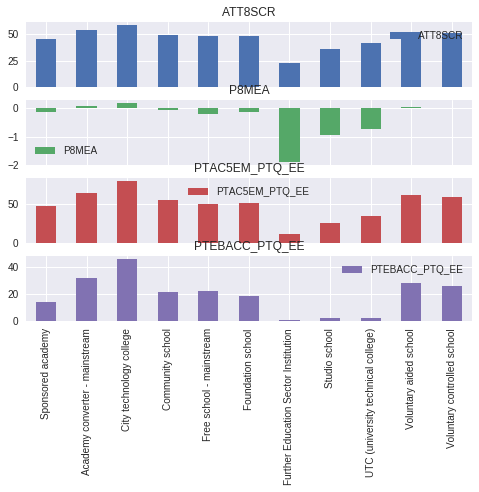

In [135]:
# visualise them quickly
grouped_df.plot(kind='bar', subplots=True)

Interesting there appears to be something of a pattern in these groupings.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f02f2ad0c18>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f02f0f70fd0>], dtype=object)

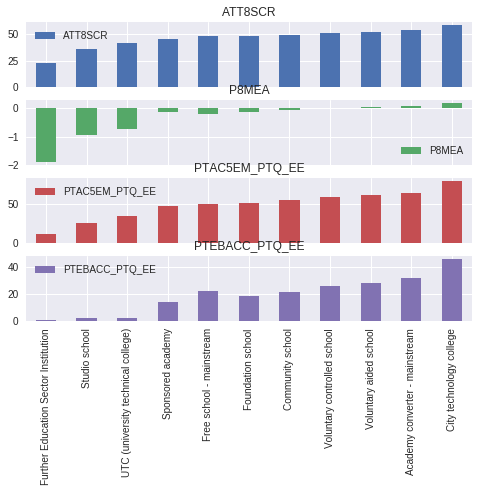

In [136]:
# sort the values to compare
grouped_df.sort_values('PTAC5EM_PTQ_EE').plot(kind='bar', subplots=True)

In [120]:
ks4_expanded_name['P8MEA']

'Progress 8 measure'

Let's tidy up these plots a little by adding human readable codes.  Changing percentages into 0-100 values.

In [121]:
# provide human readable codes
grouped_df.index = [nftypes[code] for code in grouped_df.index]

In [122]:
# make the percentages range from 0-100
grouped_df['PTAC5EM_PTQ_EE'] = grouped_df['PTAC5EM_PTQ_EE']*100
grouped_df['PTEBACC_PTQ_EE'] = grouped_df['PTEBACC_PTQ_EE']*100

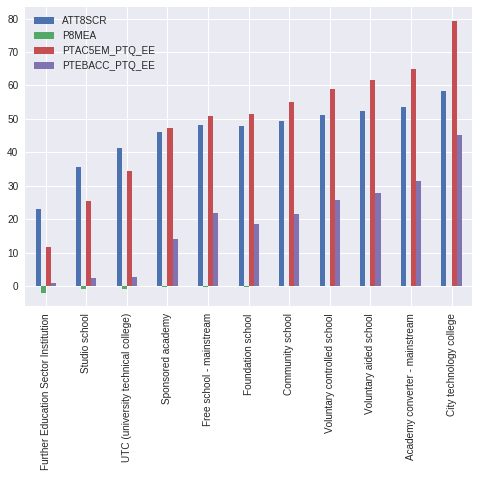

In [123]:
grouped_df.sort_values('PTAC5EM_PTQ_EE').plot(kind='bar')

There does appear to be a relationship between school type and the results acheived. using the three most common measures.  The mean values for the school type appears to relate to the other measures.

Lets see them in pairs to see how they compare.

## Plot of mean EBACC to GCSE performance by school type (%)

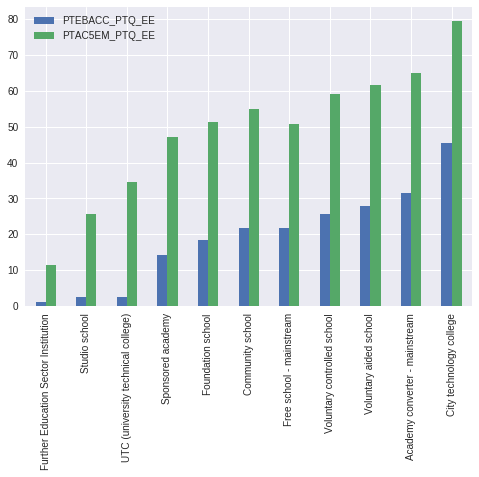

In [158]:
grouped_df[['PTEBACC_PTQ_EE', 'PTAC5EM_PTQ_EE']].sort_values('PTEBACC_PTQ_EE').plot(kind="bar")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f02f1f307b8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f02f295a198>], dtype=object)

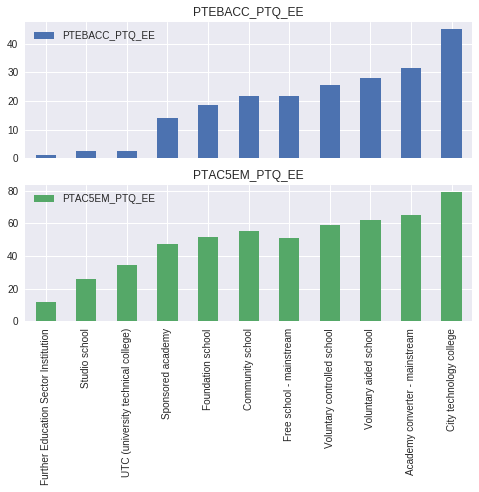

In [159]:
grouped_df[['PTEBACC_PTQ_EE', 'PTAC5EM_PTQ_EE']].sort_values('PTEBACC_PTQ_EE').plot(kind="bar", subplots=True)

There appears to be a link between EBacc and GCSE performance and the the school type.

## Plot of mean Attainment8 to Progress8 performance by school type

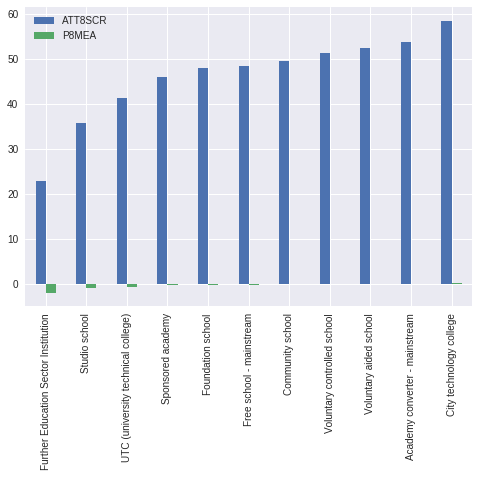

In [156]:
grouped_df[['ATT8SCR', 'P8MEA']].sort_values('ATT8SCR').plot(kind="bar")

this isn't that clear - I'll use subplots to show more clearly.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f02f2a9d7f0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f02f2a3d6d8>], dtype=object)

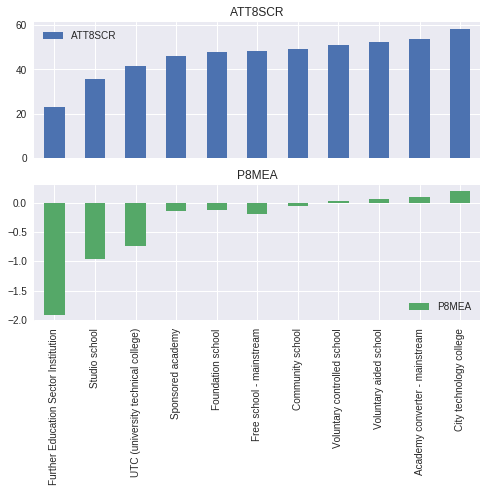

In [160]:
grouped_df[['ATT8SCR', 'P8MEA']].sort_values('ATT8SCR').plot(kind="bar", subplots=True)

In all of these cases there appears to be a pattern.  Let's get the top performers and low performers for each measure.

In [185]:
for c in grouped_df.columns:
    p = grouped_df[c].idxmax(), grouped_df[c].idxmin()
    print(c, ': ', ks4_expanded_name[c])
    print('Top school type: ', round(grouped_df.loc[p[0]][c], 2), p[0])
    print('Bottom school type', round(grouped_df.loc[p[1]][c], 2), p[1], '\n')

ATT8SCR :  Average Attainment 8 score per pupil
Top school type:  58.43 City technology college
Bottom school type 22.93 Further Education Sector Institution 

P8MEA :  Progress 8 measure
Top school type:  0.19 City technology college
Bottom school type -1.91 Further Education Sector Institution 

PTAC5EM_PTQ_EE :  Percentage of pupils achieving 5+ A*-C or equivalents including A*-C in both English and mathematics GCSEs
Top school type:  79.33 City technology college
Bottom school type 11.58 Further Education Sector Institution 

PTEBACC_PTQ_EE :  Percentage of key stage 4 pupils achieving the English Baccalaureate
Top school type:  45.33 City technology college
Bottom school type 1.08 Further Education Sector Institution 



Clearly by every measure considered _City Technology College_ are top and the _Further Education Sector Institutions_ are bottom.

## Double checking - accounting for the potential extra 0.0 values

In the data preparation phase we used the p2f function.  However, some of the values may have been set to 0 and could be skewing these analysis.  However, there are only a small number of values.  I will calculate the mean value of the column without them and replace the 0 with those and see whether it negatively impacts the results of the earlier findings.

I'll repeat the same steps without the 0.0 values that could be influenced by the import.  To compare.

In [191]:
# filter out the rows that could be effected
res = ks4_results_df[(ks4_results_df['PTAC5EM_PTQ_EE']!=0) & (ks4_results_df['PTEBACC_PTQ_EE']!=0)]

# group the data by school type
grouped_res = res[['NFTYPE', 'ATT8SCR', 'P8MEA', 'PTAC5EM_PTQ_EE', 'PTEBACC_PTQ_EE']].groupby(by='NFTYPE').mean()
grouped_gt0_df = pd.DataFrame(grouped_res)
grouped_gt0_df

,ATT8SCR,P8MEA,PTAC5EM_PTQ_EE,PTEBACC_PTQ_EE
NFTYPE,,,,
AC,46.035101,-0.137733,0.473327,0.145539
ACC,53.682992,0.096454,0.650364,0.315862
CTC,58.433333,0.190000,0.793333,0.453333
CY,49.484398,-0.053722,0.552857,0.219060
F,49.862500,-0.105417,0.549583,0.245000
FD,48.011029,-0.118713,0.515515,0.187279
FESI,33.775000,-1.040000,0.255000,0.032500
FSS,46.150000,-0.282500,0.466250,0.093750
FUTC,45.891667,-0.551667,0.400000,0.057500


In [125]:
# make the percentages prettier (out of 100)
grouped_gt0_df['PTAC5EM_PTQ_EE'] = grouped_gt0_df['PTAC5EM_PTQ_EE']*100
grouped_gt0_df['PTEBACC_PTQ_EE'] = grouped_gt0_df['PTEBACC_PTQ_EE']*100

In [198]:
# provide human readable codes
grouped_gt0_df.index = [nftypes[code] for code in grouped_gt0_df.index]

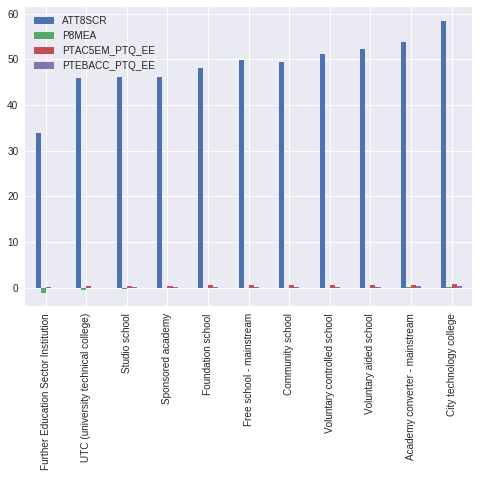

In [199]:
grouped_gt0_df.sort_values('P8MEA').plot(kind='bar')

## Plot of EBACC to GCSE performance by school type (%) non-0


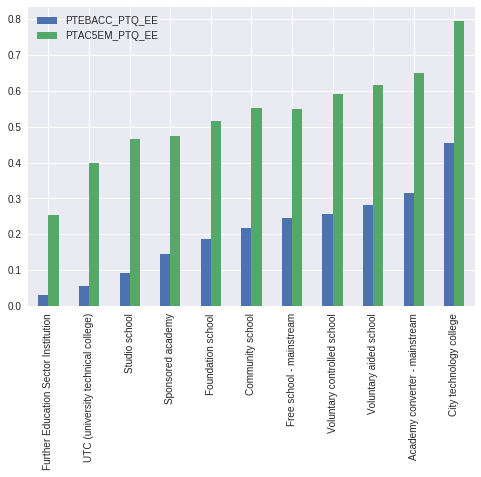

In [200]:
grouped_gt0_df[['PTEBACC_PTQ_EE', 'PTAC5EM_PTQ_EE']].sort_values('PTEBACC_PTQ_EE').plot(kind="bar")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f02f2816780>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f02e94f0630>], dtype=object)

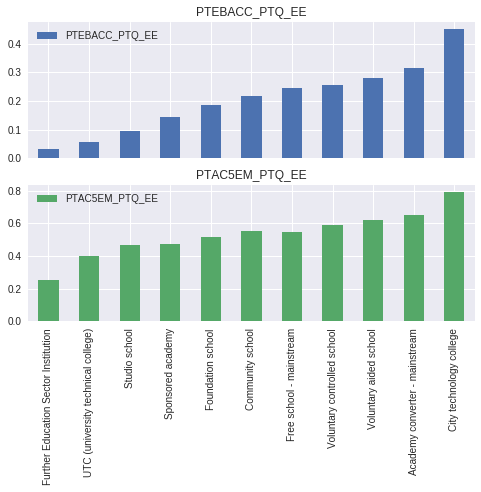

In [201]:
grouped_gt0_df[['PTEBACC_PTQ_EE', 'PTAC5EM_PTQ_EE']].sort_values('PTEBACC_PTQ_EE').plot(kind="bar", subplots=True)

There appears to be a link between EBacc and GCSE performance and the the school type.

## Plot of Attainment8 to Progress8 performance by school type ( non 0 )

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f02eb84b550>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f02f2383390>], dtype=object)

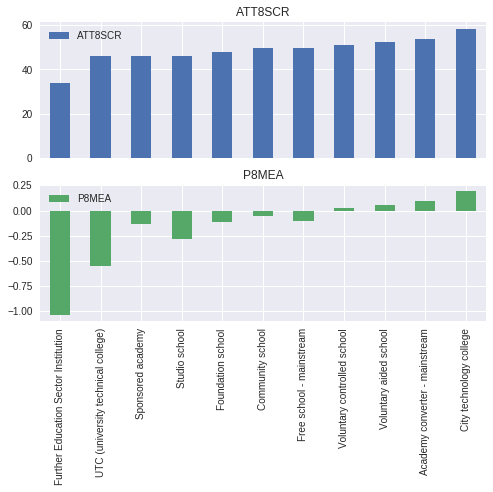

In [202]:
grouped_gt0_df[['ATT8SCR', 'P8MEA']].sort_values('ATT8SCR').plot(kind="bar", subplots=True)

In all of these cases there appears to be a pattern.  Let's get the top performers and low performers for each measure.

In [203]:
for c in grouped_gt0_df.columns:
    p = grouped_gt0_df[c].idxmax(), grouped_gt0_df[c].idxmin()
    print(c, ': ', ks4_expanded_name[c])
    print('Top school type: ', round(grouped_gt0_df.loc[p[0]][c], 2), p[0])
    print('Bottom school type', round(grouped_gt0_df.loc[p[1]][c], 2), p[1], '\n')

ATT8SCR :  Average Attainment 8 score per pupil
Top school type:  58.43 City technology college
Bottom school type 33.78 Further Education Sector Institution 

P8MEA :  Progress 8 measure
Top school type:  0.19 City technology college
Bottom school type -1.04 Further Education Sector Institution 

PTAC5EM_PTQ_EE :  Percentage of pupils achieving 5+ A*-C or equivalents including A*-C in both English and mathematics GCSEs
Top school type:  0.79 City technology college
Bottom school type 0.26 Further Education Sector Institution 

PTEBACC_PTQ_EE :  Percentage of key stage 4 pupils achieving the English Baccalaureate
Top school type:  0.45 City technology college
Bottom school type 0.03 Further Education Sector Institution 



So even after adjusting for those measures that aren't 0, for the small number that potentially got added.  The underlying results have not been effected.

However these findings are based on mean grouped values.  To get more clarity the next step is to use machine machine learning to cluster the ungrouped data and then look at each cluster group to see the distributions of school types in each group. 

In [207]:
# Clean up the now to be unused df

In [205]:
del grouped_df, grouped_gt0_df, grouped_res

There does appear to be a some kind of link between the type of school and the results of both English Baccalaurete and the older 5+A*-C GCSEs.

The correlation between 5+A*-C and the EBacc makes sense because to acheive an eBacc is across a variety of subjects including Maths, English, Sciences, language and history or geography.  Naturally, there will be a correlation between the two.

In [206]:
<a name='machine_learning'></a>

SyntaxError: invalid syntax (<ipython-input-206-c6a19a5684fb>, line 1)

# Machine Learning

# Visualisations

In [ ]:
grouped_df.plot(kind='scatter', x='P8MEA', y='PTAC5EM_PTQ_EE')

# Initial Cluster analysis

I'll follow the steps in the module materials p21.1

In [ ]:
# make a dataframe for just these two measures
p8_ac_df = grouped_df[['P8MEA', 'PTAC5EM_PTQ_EE']]
p8_ac_df

### initial values for k = 2


In [ ]:
initialCentroids_df = pd.DataFrame({'P8MEA': [-1.5, 0], 
                                    'PTAC5EM_PTQ_EE': [0.4, 0.5]}, 
                                   columns=['P8MEA', 'PTAC5EM_PTQ_EE'])

initialCentroids_df

and plot these on a scatter plot with the data points:

In [ ]:
plt.scatter(p8_ac_df['P8MEA'], p8_ac_df['PTAC5EM_PTQ_EE'])

plt.xlabel('Progress 8 measure')
plt.ylabel('5+A*-C GCSE')

plt.title('School Type KS4 performance 2015-2016 with initial cluster centroids')

# Plot the initial centroids:
for i in initialCentroids_df.index:
    plt.plot(initialCentroids_df.iloc[i]['P8MEA'],
             initialCentroids_df.iloc[i]['PTAC5EM_PTQ_EE'],
             color='black', marker='x', mew=2)

In [ ]:
# initialise the clustering object
kmeans2 = cluster.KMeans(n_clusters=2,
                         init=initialCentroids_df)

In [ ]:
# fit the object to the data
assignedClusters_clust = kmeans2.fit(p8_ac_df[['P8MEA', 'PTAC5EM_PTQ_EE']])
assignedClusters_clust.labels_

... and plot the clustered data along with the final centroids:

In [ ]:
# Plot the data points which is in the cluster labelled '0'
plt.scatter(p8_ac_df['P8MEA'][assignedClusters_clust.labels_==0],
            p8_ac_df['PTAC5EM_PTQ_EE'][assignedClusters_clust.labels_==0],
            color='red', marker='o', label='cluster 0')

# Plot the data points which is in the cluster labelled '1'
plt.scatter(p8_ac_df['P8MEA'][assignedClusters_clust.labels_==1],
            p8_ac_df['PTAC5EM_PTQ_EE'][assignedClusters_clust.labels_==1],
            color='blue', marker='o', label='cluster 1')

# plot each of the centroids:
for (cx, cy) in assignedClusters_clust.cluster_centers_:
    plt.plot(cx, cy, color='black', marker='x', mew=2)
    
plt.legend()

plt.xlabel('Progress 8 measure')
plt.ylabel('5+A*-C GCSE')

plt.title('School Type KS4 performance 2015-2016 2-means clustering with centroids')

plt.plot()


## Lets try k=4

In [ ]:
import random
# set the seed so that analysis is consitent on each run.
random.seed(283)

In [ ]:
# helper function to quickly generate a dataframe 
# of a given number of random centroidsto speeg
def random_centroids(x_range, y_range, num_centroids):
    centroids = collections.defaultdict(list)
    for i in range(num_centroids):
        centroids['A'].append(random.uniform(min(x_range), max(x_range)))
        centroids['B'].append(random.uniform(min(y_range), max(y_range)))
    
    return pd.DataFrame(centroids)

# generate 3 different sets of centroids
initialCentroids_a = random_centroids([-2,0.25], [0.2, 0.9], 4)
initialCentroids_b = random_centroids([-2,0.25], [0.2, 0.9], 4)
initialCentroids_c = random_centroids([-2,0.25], [0.2, 0.9], 4)


In [ ]:
initialCentroids_a

In [ ]:
initialCentroids_b

In [ ]:
initialCentroids_c

In [ ]:
# create 3 corresponding k-means clusters
kmeans4_a = cluster.KMeans(n_clusters=4, init=initialCentroids_a)
kmeans4_b = cluster.KMeans(n_clusters=4, init=initialCentroids_b)
kmeans4_c = cluster.KMeans(n_clusters=4, init=initialCentroids_c)

In [ ]:
# fit the cluster object to the data
assignedClusters_clust_a = kmeans4_a.fit(p8_ac_df[['P8MEA', 'PTAC5EM_PTQ_EE']])
assignedClusters_clust_b = kmeans4_b.fit(p8_ac_df[['P8MEA', 'PTAC5EM_PTQ_EE']])
assignedClusters_clust_c = kmeans4_c.fit(p8_ac_df[['P8MEA', 'PTAC5EM_PTQ_EE']])

In [ ]:
# Helper function to plot clustering results, 
# colors do not need to be set unless num is greater than 6
def plot_cluster(data_x, data_y, assigned_clust, k, 
                 cluster_labels=None, plt_labels=None, 
                 plt_title=None, colors=None):
    # set default colors
    if colors==None:
        colors = sns.palettes.color_palette(n_colors=k)
    # set default labels
    if cluster_labels==None:
        cluster_labels = range(k)
    
    plt.figure()
    # plot the cluster group    
    for c in range(k):
        plt.scatter(data_x[assigned_clust.labels_==c],
                    data_y[assigned_clust.labels_==c],
                    color=colors[c], marker='o', label=cluster_labels[c],
                   )
    
    for (cx, cy) in assigned_clust.cluster_centers_:
        plt.plot(cx, cy, color='black', marker='x', mew=2)
    
    plt.legend()
    
    plt.xlabel(plt_labels[0])
    plt.ylabel(plt_labels[1])
        
    plt.title(plt_title)


In [ ]:
# plot the first trial
plot_cluster(p8_ac_df['P8MEA'], p8_ac_df['PTAC5EM_PTQ_EE'], assignedClusters_clust_a, 4,
             cluster_labels=['a', 'b', 'c', 'd'],
             plt_labels=['Progress 8', '5+A*-C GCSE'],
             plt_title='School Type KS4 performance 2015-2016 4-means clustering with centroids A')

In [ ]:
# plot the second trial
plot_cluster(p8_ac_df['P8MEA'], p8_ac_df['PTAC5EM_PTQ_EE'], assignedClusters_clust_b, 4,
             cluster_labels=['a', 'b', 'c', 'd'],
             plt_labels=['Progress 8', '5+A*-C GCSE'],
             plt_title='School Type KS4 performance 2015-2016 4-means clustering with centroids B')

In [ ]:
# Plot the third trial
plot_cluster(p8_ac_df['P8MEA'], p8_ac_df['PTAC5EM_PTQ_EE'], assignedClusters_clust_c, 4,
             cluster_labels=['a', 'b', 'c', 'd'],
             plt_labels=['Progress 8', '5+A*-C GCSE'],
             plt_title='School Type KS4 performance 2015-2016 4-means clustering with centroids C')

Let's try some other values of k

### K = 5

In [ ]:
#  generate 3 sets of random centroids
init_centroids_5a = random_centroids([-2, 0.25], [0.2,0.85], 5)
init_centroids_5b = random_centroids([-2, 0.25], [0.2,0.85], 5)
init_centroids_5c = random_centroids([-2, 0.25], [0.2,0.85], 5)

In [ ]:
# create 3 corresponding k-means clusters
kmeans5_a = cluster.KMeans(n_clusters=5, init=init_centroids_5a)
kmeans5_b = cluster.KMeans(n_clusters=5, init=init_centroids_5b)
kmeans5_c = cluster.KMeans(n_clusters=5, init=init_centroids_5c)

In [ ]:
# fit the object to the data
assigned_clust_a = kmeans5_a.fit(p8_ac_df[['P8MEA', 'PTAC5EM_PTQ_EE']])
assigned_clust_b = kmeans5_b.fit(p8_ac_df[['P8MEA', 'PTAC5EM_PTQ_EE']])
assigned_clust_c = kmeans5_c.fit(p8_ac_df[['P8MEA', 'PTAC5EM_PTQ_EE']])


In [ ]:
# Plot the first trial
plot_cluster(p8_ac_df['P8MEA'], p8_ac_df['PTAC5EM_PTQ_EE'], assigned_clust_a, 5,
             cluster_labels=['a', 'b', 'c', 'd', 'e'],
             plt_labels=['Progress 8', '5+A*-C GCSE'],
             plt_title='School Type KS4 performance 2015-2016\n5-means clustering with centroids A')

In [ ]:
# Plot the second trial
plot_cluster(p8_ac_df['P8MEA'], p8_ac_df['PTAC5EM_PTQ_EE'], 
             assigned_clust_b, 5,
             cluster_labels=['a', 'b', 'c', 'd', 'e'],
             plt_labels=['Progress 8', '5+A*-C GCSE'],
             plt_title='School Type KS4 performance 2015-2016\n5-means clustering with centroids b')

In [ ]:
# Plot the third trial
plot_cluster(p8_ac_df['P8MEA'], p8_ac_df['PTAC5EM_PTQ_EE'], 
             assigned_clust_c, 5,
             cluster_labels=['a', 'b', 'c', 'd', 'e'],
             plt_labels=['Progress 8', '5+A*-C GCSE'],
             plt_title='School Type KS4 performance 2015-2016\n5-means clustering with centroids b')

These clusterings show that the higher the k-value gets the less stable the results are.  k=4 seems to give the most consistent groupings for randomly initialised centroids.

I'll quickly do 5 trials of k=4 to see if they stay consistent.

In [ ]:
#  generate 3 sets of random centroids
init_centroids_4a = random_centroids([-2, 0.25], [0.2,0.85], 4)
init_centroids_4b = random_centroids([-2, 0.25], [0.2,0.85], 4)
init_centroids_4c = random_centroids([-2, 0.25], [0.2,0.85], 4)
init_centroids_4d = random_centroids([-2, 0.25], [0.2,0.85], 4)
init_centroids_4e = random_centroids([-2, 0.25], [0.2,0.85], 4)

In [ ]:
# create 3 corresponding k-means clusters
kmeans4_a = cluster.KMeans(n_clusters=4, init=init_centroids_4a)
kmeans4_b = cluster.KMeans(n_clusters=4, init=init_centroids_4b)
kmeans4_c = cluster.KMeans(n_clusters=4, init=init_centroids_4c)
kmeans4_d = cluster.KMeans(n_clusters=4, init=init_centroids_4d)
kmeans4_e = cluster.KMeans(n_clusters=4, init=init_centroids_4e)

In [ ]:
# fit the object to the data
assigned_clust_a = kmeans4_a.fit(p8_ac_df[['P8MEA', 'PTAC5EM_PTQ_EE']])
assigned_clust_b = kmeans4_b.fit(p8_ac_df[['P8MEA', 'PTAC5EM_PTQ_EE']])
assigned_clust_c = kmeans4_c.fit(p8_ac_df[['P8MEA', 'PTAC5EM_PTQ_EE']])
assigned_clust_d = kmeans4_d.fit(p8_ac_df[['P8MEA', 'PTAC5EM_PTQ_EE']])
assigned_clust_e = kmeans4_e.fit(p8_ac_df[['P8MEA', 'PTAC5EM_PTQ_EE']])



In [ ]:
# Plot the first trial
plot_cluster(p8_ac_df['P8MEA'], p8_ac_df['PTAC5EM_PTQ_EE'], 
             assigned_clust_a, 4,
             cluster_labels=['a', 'b', 'c', 'd'],
             plt_labels=['Progress 8', '5+A*-C GCSE'],
             plt_title='School Type KS4 performance 2015-2016\n4-means clustering with centroids A')

In [ ]:
# Plot the first trial
plot_cluster(p8_ac_df['P8MEA'], p8_ac_df['PTAC5EM_PTQ_EE'], 
             assigned_clust_b, 4,
             cluster_labels=['a', 'b', 'c', 'd'],
             plt_labels=['Progress 8', '5+A*-C GCSE'],
             plt_title='School Type KS4 performance 2015-2016\n4-means clustering with centroids B')

In [ ]:
# Plot the first trial
plot_cluster(p8_ac_df['P8MEA'], p8_ac_df['PTAC5EM_PTQ_EE'], 
             assigned_clust_c, 4,
             cluster_labels=['a', 'b', 'c', 'd'],
             plt_labels=['Progress 8', '5+A*-C GCSE'],
             plt_title='School Type KS4 performance 2015-2016\n4-means clustering with centroids C')

In [ ]:
# Plot the first trial
plot_cluster(p8_ac_df['P8MEA'], p8_ac_df['PTAC5EM_PTQ_EE'], 
             assigned_clust_d, 4,
             cluster_labels=['a', 'b', 'c', 'd'],
             plt_labels=['Progress 8', '5+A*-C GCSE'],
             plt_title='School Type KS4 performance 2015-2016\n4-means clustering with centroids D')

In [ ]:
# Plot the first trial
plot_cluster(p8_ac_df['P8MEA'], p8_ac_df['PTAC5EM_PTQ_EE'], 
             assigned_clust_e, 4,
             cluster_labels=['a', 'b', 'c', 'd'],
             plt_labels=['Progress 8', '5+A*-C GCSE'],
             plt_title='School Type KS4 performance 2015-2016\n4-means clustering with centroids E')

There are clearly a few ways that this dataset can be clustered.  It is perhaps worth noting that the most of the school types are around the national average measure for Progress8 (0), and above 50% for the GCSE measure.  Their are two clear outliers one at the top right (best score for both GCSE, and progress8) and one at the bottom (second worse GCSE and by far the worse progress8), let's identify which school types they are.

In [ ]:
nftypes[p8_ac_df['P8MEA'].idxmax()]

In [ ]:
nftypes[p8_ac_df['P8MEA'].idxmin()]

In [ ]:
nftypes[p8_ac_df['PTAC5EM_PTQ_EE'].idxmax()]

In [ ]:
nftypes[p8_ac_df['PTAC5EM_PTQ_EE'].idxmin()]

In [ ]:
ks4_results_df[ks4_results_df['NFTYPE']=='CTC'].count()

In [ ]:
ks4_results_df[ks4_results_df['NFTYPE']=='FSS'].count()

In [ ]:
ks4_results_df[ks4_results_df['NFTYPE']=='FESI'].count()

In [ ]:
nftypes

In [ ]:
ks4_results_df.head()

In [ ]:
# Top performing schools for each column
for c in grouped_df.columns:
    top = grouped_df[c].idxmax()
    bottom = grouped_df[c].idxmin()
    
    print(c, ':\nTop performer:', nftypes[top], 
          '\nBottom performer:', nftypes[bottom],'\n')

<a name="machine_learning"></a>

# Machine Learning

## k-means cluster analysis of the ungrouped dataset.

In [ ]:
ks4_results_df.head()

In [ ]:
ks4_results_df.plot(kind='scatter', x='P8MEA', y='PTAC5EM_PTQ_EE')

With there being a range of different measures to look at in combination I will create another helper function to make the process more efficient.

In [ ]:
# helper function to fill out boilerplate code
def kmeans_plot(df, x_column, y_column, k,
                cluster_labels=None, plt_labels=None, plt_title=None,
                colors=None
                ):

    # determine the ranges of the data
    x_range = [min(df[x_column]), max(df[y_column])]
    y_range = [min(df[x_column]), max(df[y_column])]

    # generate sets of random centroids
    init_centroids = random_centroids(x_range, y_range, k)

    # create k-means cluster object
    kmeans_clust = cluster.KMeans(n_clusters=k, init=init_centroids)

    # fit the objest to the data
    assigned_clust = kmeans_clust.fit(df[[x_column, y_column]])

    # plot the kmeans cluster
    plot_cluster(df[x_column], df[y_column], assigned_clust, k,
                 cluster_labels=cluster_labels, plt_labels=plt_labels,
                 plt_title=plt_title, colors=colors
                 )

In [ ]:
# test it works
kmeans_plot(ks4_results_df, 'P8MEA', 'PTAC5EM_PTQ_EE', 4,
            plt_title='KS4 results cluster groups k=4',
            plt_labels=['Progress 8', '5+A*-C'])

Nice, but we are still getting the runtime error.  A quck search on Stack overflow shows that we don't need to generate initial centroids.  So I'll adapt the code so we can add specific ones if wanted.  Otherwise , the method will use the default of 10 random iterations.
[stack overflow link](https://stackoverflow.com/questions/28862334/k-means-with-selected-initial-centers)

In [ ]:
# helper function to fill out boilerplate code
# initialises a kmeans cluster object and fits it to the data
# then plots it
def kmeans_plot(df, x_column, y_column, k,
                cluster_labels=None, plt_labels=None, plt_title=None,
                colors=None, initial_centroids=None
                ):
    
    # create k-means cluster object
    if initial_centroids == None:
        kmeans_clust = cluster.KMeans(n_clusters=k)
    else:
        kmeans_clust = cluster.KMeans(n_clusters=k, init=initial_centroids)
    # fit the objest to the data
    assigned_clust = kmeans_clust.fit(df[[x_column, y_column]])

    # plot the kmeans cluster
    plot_cluster(df[x_column], df[y_column], assigned_clust, k,
                 cluster_labels=cluster_labels, plt_labels=plt_labels,
                 plt_title=plt_title, colors=colors
                 )

Now I have a handy function I can iterate through different k-values and see which k value fits the data the best.

## Cluster Groups of Progress 8 and 5+A*-C measures

Remind myself of the column names so I can look them up

In [ ]:
ks4_results_df.columns


In [ ]:
for k in range(2,7):
    title = 'KS4 results cluster groups k=' + str(k)
    cluster_labels = ['Group ' + str(i) for i in range(k)]
    kmeans_plot(ks4_results_df, 'P8MEA', 'PTAC5EM_PTQ_EE', k=k,
                plt_title=title, cluster_labels=cluster_labels,
                plt_labels=['Progress 8', '%+A*-C GCSE'])

The additional clusters seem to break the data into narrow and narrower segments.  For our needs I think k=4 is good.

In [ ]:
title = 'KS4 results cluster groups k=4'
cluster_labels = ['Group ' + str(i) for i in range(4)]

kmeans_plot(ks4_results_df, 'P8MEA', 'PTAC5EM_PTQ_EE', k=4,
                plt_title=title, cluster_labels=cluster_labels,
                plt_labels=['Progress 8', '%+A*-C GCSE'])

I need a little more control over the plotting so I can move the set the legend position if needed.

In [ ]:
# Helper function to plot clustering results, 
# colors do not need to be set unless num is greater than 6
def plot_cluster(data_x, data_y, assigned_clust, k, 
                 cluster_labels=None, plt_labels=None, 
                 plt_title=None, colors=None, legend_loc=None):
    # set default colors
    if colors==None:
        colors = sns.palettes.color_palette(n_colors=k)
    # set default labels
    if cluster_labels==None:
        cluster_labels = ['Group ' + str(i) for i in range(k)]
    
    plt.figure()
    # plot the cluster group    
    for c in range(k):
        plt.scatter(data_x[assigned_clust.labels_==c],
                    data_y[assigned_clust.labels_==c],
                    color=colors[c], marker='o', label=cluster_labels[c],
                   )
    # plot the centroids
    for (cx, cy) in assigned_clust.cluster_centers_:
        plt.plot(cx, cy, color='black', marker='x', mew=2)
    
    # add the legend
    plt.legend(loc=legend_loc)
        
    plt.xlabel(plt_labels[0])
    plt.ylabel(plt_labels[1])
        
    plt.title(plt_title)



In [ ]:
# helper function to fill out boilerplate code
# initialises a kmeans cluster object and fits it to the data
# then plots it
def kmeans_plot(df, x_column, y_column, k,
                cluster_labels=None, plt_labels=None, plt_title=None,
                colors=None, initial_centroids=None, legend_loc=None
                ):
    
    # create k-means cluster object
    if initial_centroids == None:
        kmeans_clust = cluster.KMeans(n_clusters=k)
    else:
        kmeans_clust = cluster.KMeans(n_clusters=k, init=initial_centroids)
    # fit the objest to the data
    assigned_clust = kmeans_clust.fit(df[[x_column, y_column]])

    # plot the kmeans cluster
    plot_cluster(df[x_column], df[y_column], assigned_clust, k,
                 cluster_labels=cluster_labels, plt_labels=plt_labels,
                 plt_title=plt_title, colors=colors, legend_loc=legend_loc
                 )

In [ ]:
title = 'KS4 results cluster groups k=4'

kmeans_plot(ks4_results_df, 'P8MEA', 'PTAC5EM_PTQ_EE', k=4,
            plt_title=title,
            plt_labels=['Progress 8', '%+A*-C GCSE'],

            legend_loc=(1.05, 0.5))

## Cluster Groups of Attainment 8 and 5+A*-C measures

Remind myself of the column names so I can cluster on them.

In [ ]:
ks4_results_df.columns

In [ ]:
# Iterate through a few values of k
for k in range(2,6):
    title = 'KS4 results cluster groups k=' + str(k)
    kmeans_plot(ks4_results_df, 'ATT8SCR', 'PTAC5EM_PTQ_EE', k=k,
                plt_title=title,
                plt_labels=['ATT8SCR (Average)', '+A*-C GCSE (%)'])

Again k=4 looks good. So I'll do a single plot of that.

Looking through these groupings I will use k=4 as the way to group the data.  That way I can rank the performance of the schools by their inclusion in a group.  I'll quickly plot out each of the cluster analysis I will use as measures below.

Then I will add a column for each measure to the dataframe and the group that the school was added to. Using the cluster groupings

## Attainment 8 and 5+ A*-C GCSE cluster analysis k=4

In [ ]:
title = 'KS4 results cluster groups k=4'

kmeans_plot(ks4_results_df, 'P8MEA', 'PTAC5EM_PTQ_EE', k=4,
            plt_title=title,
            plt_labels=['Progress 8', '%+A*-C GCSE'],
            legend_loc=(1.05, 0.5))

## Cluster Groups of Attainment 8 and English Baccalaurete measures

Remind myself of the column names so I can cluster on them.

In [ ]:
ks4_results_df.columns

In [ ]:
# Iterate through a few values of k
for k in range(2,5):
    title = 'KS4 results cluster groups k=' + str(k)
    kmeans_plot(ks4_results_df, 'ATT8SCR', 'PTEBACC_PTQ_EE', k=k,
                plt_title=title, cluster_labels=cluster_labels,
                plt_labels=['ATT8SCR (Average)', 'English Baccalaurete (%)'])

## Attainment 8 and Progress 8 cluster group analysis k=4


In [ ]:
title = 'KS4 results cluster groups k=3'

kmeans_plot(ks4_results_df, 'ATT8SCR', 'P8MEA', k=4,
            plt_title=title,
            plt_labels=['Attainment 8', 'Progress 8'],
            legend_loc=[1.05, 0.5]
           )

In [ ]:
## Progress 8 and 5 A*-C at GCSE cluster groups k=3


In [ ]:
title = 'KS4 results cluster groups k=3'

kmeans_plot(ks4_results_df, 'P8MEA', 'PTAC5EM_PTQ_EE', k=3,
            plt_title=title,
            plt_labels=['Progress 8', '+A*-C GCSE'],
            legend_loc=(1.05, 0.5))

In [ ]:
# helper function to fill out boilerplate code
# initialises a kmeans cluster object and fits it to the data
# then plots it
def kmeans_plot(df, x_column, y_column, k,
                cluster_labels=None, plt_labels=None, plt_title=None,
                colors=None, initial_centroids=None, legend_loc=None,
                assigned_clust=None,
                ):
    
    
    if assigned_clust == None:
        # create k-means cluster object
        if initial_centroids == None:
            kmeans_clust = cluster.KMeans(n_clusters=k)
        else:
            kmeans_clust = cluster.KMeans(n_clusters=k, init=initial_centroids)
        # fit the objest to the data
        assigned_clust = kmeans_clust.fit(df[[x_column, y_column]])

    # plot the kmeans cluster
    plot_cluster(df[x_column], df[y_column], assigned_clust, k,
                 cluster_labels=cluster_labels, plt_labels=plt_labels,
                 plt_title=plt_title, colors=colors, legend_loc=legend_loc
                 )

In [ ]:
# create cluster groups
kmeans_cluster = cluster.KMeans(n_clusters=4)
assigned_cluster = kmeans_cluster.fit(ks4_results_df[['P8MEA', 'PTAC5EM_PTQ_EE']])


In [ ]:
kmeans_plot(ks4_results_df, 'P8MEA', 'PTAC5EM_PTQ_EE', 4,
            plt_labels=['Progress 8', '5+ A*-C GCSE (%)'],
            assigned_clust=assigned_cluster)

In [ ]:
# manually label the cluster groupings in order of performance
a_df = ks4_results_df[['P8MEA', 'PTAC5EM_PTQ_EE', 'NFTYPE']][assigned_cluster.labels_==2]
b_df = ks4_results_df[['P8MEA', 'PTAC5EM_PTQ_EE', 'NFTYPE']][assigned_cluster.labels_==0]
c_df = ks4_results_df[['P8MEA', 'PTAC5EM_PTQ_EE', 'NFTYPE']][assigned_cluster.labels_==3]
d_df = ks4_results_df[['P8MEA', 'PTAC5EM_PTQ_EE', 'NFTYPE']][assigned_cluster.labels_==1]

In [ ]:
a_df['Cluster'] = 'A'
b_df['Cluster'] = 'B'
c_df['Cluster'] = 'C'
d_df['Cluster'] = 'D'

In [ ]:
a_df.describe()

In [ ]:
grp_a = ks4_clustered_df[ks4_clustered_df['Cluster']=='A'].groupby(by='NFTYPE').mean()

In [ ]:
grp_a.plot(kind='bar')

In [ ]:
a_df['NFTYPE'].count()

In [ ]:
a_df['NFTYPE'].value_counts()

In [ ]:
a_df.groupby(by='NFTYPE').mean().sort_values('ATT8SCR')

<a name="todo1">TODO</a>

- tidy up plots
- write up steps
- conclusions


striate the dataset?


<a name="q2"></a>

#  Q2 - Keystage 2 and 4 Investigation.  Do schools that perform well at KS2 deliver as good or better results at KS4.

The first thing I need to decide before I can analyse the data is to decide what I mean by 'good performance' and which measures I will use to compare

### Descriptive analysis

### Choosing the measures I will use to compare the schools

### What flaws are there in the data/subset of data that could impact findings

### Carry out some analysis resulting in a few plots that convey findings

### Run some statistical tests

### Summarise findings

# Cleanup/remove the database
<a name="cleanup"></a>

Uncomment the lines below to remove the MongoDB created in the investigation.

In [ ]:
# uncomment to remove the database if needed
# client.drop_database('schools_db')
# client.database_names()

In [146]:
## chi_squared testing

    # Since all values MUST be positive we will omit `P8MEA`
    chi2, p, _, _, = scipy.stats.chi2_contingency(
        grouped_df[['ATT8SCR', 'PTAC5EM_PTQ_EE', 'PTEBACC_PTQ_EE']])

    chi2, p

IndentationError: unexpected indent (<ipython-input-146-78219854617b>, line 4)